In [2]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [4]:
# from pygam import GAM, s

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

In [7]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy import stats

In [9]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning

In [8]:
import scipy
import sklearn

In [11]:
print(scipy.__version__)
print(sklearn.__version__)

1.14.1
1.5.2


Data Importing & Cleaning

In [9]:
data = pd.read_csv('VIX_data.csv')

In [13]:
data.head()

Date  Unemployment Rate      CPI  Three Month T Bill Rate  \
0  2014-10-01                5.7  237.430                     0.02   
1  2014-11-01                5.8  236.983                     0.02   
2  2014-12-01                5.6  236.252                     0.03   
3  2015-01-01                5.7  234.747                     0.03   
4  2015-04-01                5.4  236.222                     0.02   

   Six Month T Bill Rate  10-Year Treasury Constant Maturity Rate  Fed Rate  \
0                   0.05                                     2.30      0.09   
1                   0.07                                     2.33      0.09   
2                   0.11                                     2.21      0.12   
3                   0.08                                     1.88      0.11   
4                   0.09                                     1.94      0.12   

   BBB Rate  SP500 Index     VIX  ...  USD INDEX Open  USD INDEX High  \
0      3.50     1928.210  16.530  ...       85.910004       87.129997   
1      3.63     2039.820  13.330  ...       87.080002       88.440002   
2      3.78     2063.890  15.155  ...       88.230003       90.330002   
3      3.64     2024.465  19.455  ...       90.360001       95.480003   
4      3.41     2097.290  13.300  ...       98.419998       99.989998   

   USD INDEX Low  USD INDEX Close  USD INDEX Adj Close   VXN Open   VXN High  \
0      84.470001        86.879997            86.879997  18.260000  31.170000   
1      86.879997        88.360001            88.360001  15.740000  17.180000   
2      87.629997        90.269997            90.269997  14.740000  24.080000   
3      90.330002        94.800003            94.800003  19.730000  23.700001   
4      94.400002        94.599998            94.599998  17.360001  18.639999   

     VXN Low  VXN Close  VXN Adj Close  
0  15.310000  15.810000      15.810000  
1  13.480000  14.740000      14.740000  
2  14.300000  19.639999      19.639999  
3  16.389999  21.590000      21.590000  
4  13.510000  16.510000      16.510000  

[5 rows x 62 columns]

In [14]:
data.shape

(103, 62)

In [15]:
data.isnull().sum()

Date                       0
Unemployment Rate          0
CPI                        0
Three Month T Bill Rate    0
Six Month T Bill Rate      0
                          ..
VXN Open                   0
VXN High                   0
VXN Low                    0
VXN Close                  0
VXN Adj Close              0
Length: 62, dtype: int64

In [16]:
(data== '').sum()

Date                       0
Unemployment Rate          0
CPI                        0
Three Month T Bill Rate    0
Six Month T Bill Rate      0
                          ..
VXN Open                   0
VXN High                   0
VXN Low                    0
VXN Close                  0
VXN Adj Close              0
Length: 62, dtype: int64

In [10]:
total_check = data.isnull().sum() + (data== '').sum()

In [18]:
has_missing_data = total_check.sum() >0
print(has_missing_data)

False


In [19]:
data.index = pd.to_datetime(data['Date'])

In [11]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
column_means = data[numeric_columns].mean()

data_filled = data.copy()
data_filled[numeric_columns].fillna(column_means)

Unemployment Rate      CPI  Three Month T Bill Rate  \
0                  5.7  237.430                     0.02   
1                  5.8  236.983                     0.02   
2                  5.6  236.252                     0.03   
3                  5.7  234.747                     0.03   
4                  5.4  236.222                     0.02   
..                 ...      ...                      ...   
98                 3.9  313.207                     5.24   
99                 4.0  313.225                     5.25   
100                4.1  313.049                     5.24   
101                4.3  313.534                     5.20   
102                4.2  314.121                     5.05   

     Six Month T Bill Rate  10-Year Treasury Constant Maturity Rate  Fed Rate  \
0                     0.05                                     2.30      0.09   
1                     0.07                                     2.33      0.09   
2                     0.11                                     2.21      0.12   
3                     0.08                                     1.88      0.11   
4                     0.09                                     1.94      0.12   
..                     ...                                      ...       ...   
98                    5.15                                     4.54      5.33   
99                    5.17                                     4.48      5.33   
100                   5.15                                     4.31      5.33   
101                   5.01                                     4.25      5.33   
102                   4.74                                     3.87      5.33   

     BBB Rate  SP500 Index     VIX        GDP  ...  USD INDEX Open  \
0        3.50     1928.210  16.530  17912.079  ...       85.910004   
1        3.63     2039.820  13.330  17912.079  ...       87.080002   
2        3.78     2063.890  15.155  17912.079  ...       88.230003   
3        3.64     2024.465  19.455  18063.529  ...       90.360001   
4        3.41     2097.290  13.300  18279.784  ...       98.419998   
..        ...          ...     ...        ...  ...             ...   
98       5.84     5108.065  15.745  29016.714  ...      104.489998   
99       5.75     5256.815  12.920  29016.714  ...      106.320000   
100      5.63     5433.740  12.645  29016.714  ...      104.629997   
101      5.53     5550.165  13.190  29016.714  ...      105.849998   
102      5.20     5548.735  16.690  29016.714  ...      104.070000   

     USD INDEX High  USD INDEX Low  USD INDEX Close  USD INDEX Adj Close  \
0         87.129997      84.470001        86.879997            86.879997   
1         88.440002      86.879997        88.360001            88.360001   
2         90.330002      87.629997        90.269997            90.269997   
3         95.480003      90.330002        94.800003            94.800003   
4         99.989998      94.400002        94.599998            94.599998   
..              ...            ...              ...                  ...   
98       106.519997     103.879997       106.220001           106.220001   
99       106.489998     104.080002       104.669998           104.669998   
100      106.129997     103.989998       105.870003           105.870003   
101      106.050003     103.650002       104.099998           104.099998   
102      104.449997     100.510002       101.699997           101.699997   

      VXN Open   VXN High    VXN Low  VXN Close  VXN Adj Close  
0    18.260000  31.170000  15.310000  15.810000      15.810000  
1    15.740000  17.180000  13.480000  14.740000      14.740000  
2    14.740000  24.080000  14.300000  19.639999      19.639999  
3    19.730000  23.700001  16.389999  21.590000      21.590000  
4    17.360001  18.639999  13.510000  16.510000      16.510000  
..         ...        ...        ...        ...            ...  
98   17.590000  23.340000  16.340000  18.430000      18.430000  
99   20.150000  20.230000  14.670000 

In [21]:
data_filled.head()

Date  Unemployment Rate      CPI  Three Month T Bill Rate  \
Date                                                                          
2014-10-01  2014-10-01                5.7  237.430                     0.02   
2014-11-01  2014-11-01                5.8  236.983                     0.02   
2014-12-01  2014-12-01                5.6  236.252                     0.03   
2015-01-01  2015-01-01                5.7  234.747                     0.03   
2015-04-01  2015-04-01                5.4  236.222                     0.02   

            Six Month T Bill Rate  10-Year Treasury Constant Maturity Rate  \
Date                                                                         
2014-10-01                   0.05                                     2.30   
2014-11-01                   0.07                                     2.33   
2014-12-01                   0.11                                     2.21   
2015-01-01                   0.08                                     1.88   
2015-04-01                   0.09                                     1.94   

            Fed Rate  BBB Rate  SP500 Index     VIX  ...  USD INDEX Open  \
Date                                                 ...                   
2014-10-01      0.09      3.50     1928.210  16.530  ...       85.910004   
2014-11-01      0.09      3.63     2039.820  13.330  ...       87.080002   
2014-12-01      0.12      3.78     2063.890  15.155  ...       88.230003   
2015-01-01      0.11      3.64     2024.465  19.455  ...       90.360001   
2015-04-01      0.12      3.41     2097.290  13.300  ...       98.419998   

            USD INDEX High  USD INDEX Low  USD INDEX Close  \
Date                                                         
2014-10-01       87.129997      84.470001        86.879997   
2014-11-01       88.440002      86.879997        88.360001   
2014-12-01       90.330002      87.629997        90.269997   
2015-01-01       95.480003      90.330002        94.800003   
2015-04-01       99.989998      94.400002        94.599998   

            USD INDEX Adj Close   VXN Open   VXN High    VXN Low  VXN Close  \
Date                                                                          
2014-10-01            86.879997  18.260000  31.170000  15.310000  15.810000   
2014-11-01            88.360001  15.740000  17.180000  13.480000  14.740000   
2014-12-01            90.269997  14.740000  24.080000  14.300000  19.639999   
2015-01-01            94.800003  19.730000  23.700001  16.389999  21.590000   
2015-04-01            94.599998  17.360001  18.639999  13.510000  16.510000   

            VXN Adj Close  
Date                       
2014-10-01      15.810000  
2014-11-01      14.740000  
2014-12-01      19.639999  
2015-01-01      21.590000  
2015-04-01      16.510000  

[5 rows x 62 columns]

In [22]:
data_filled.shape

(103, 62)

In [12]:
VIX_data = data_filled['VIX']

In [91]:
VIX_data.describe()

count    103.000000
mean      17.515971
std        5.715289
min       10.005000
25%       13.235000
50%       15.960000
75%       21.165000
max       41.380000
Name: VIX, dtype: float64

In [25]:
VIX_data.head()

Date
2014-10-01    16.530
2014-11-01    13.330
2014-12-01    15.155
2015-01-01    19.455
2015-04-01    13.300
Name: VIX, dtype: float64

In [13]:
if isinstance(VIX_data, pd.Series):
    VIX = VIX_data.to_frame(name='VIX')


In [14]:
data_interim = data_filled.reset_index(drop=True)
data_interim.set_index('Date', inplace=True)

data_interim.index = pd.to_datetime(data_interim.index)

In [27]:
data_interim.head()

Unemployment Rate      CPI  Three Month T Bill Rate  \
Date                                                              
2014-10-01                5.7  237.430                     0.02   
2014-11-01                5.8  236.983                     0.02   
2014-12-01                5.6  236.252                     0.03   
2015-01-01                5.7  234.747                     0.03   
2015-04-01                5.4  236.222                     0.02   

            Six Month T Bill Rate  10-Year Treasury Constant Maturity Rate  \
Date                                                                         
2014-10-01                   0.05                                     2.30   
2014-11-01                   0.07                                     2.33   
2014-12-01                   0.11                                     2.21   
2015-01-01                   0.08                                     1.88   
2015-04-01                   0.09                                     1.94   

            Fed Rate  BBB Rate  SP500 Index     VIX        GDP  ...  \
Date                                                            ...   
2014-10-01      0.09      3.50     1928.210  16.530  17912.079  ...   
2014-11-01      0.09      3.63     2039.820  13.330  17912.079  ...   
2014-12-01      0.12      3.78     2063.890  15.155  17912.079  ...   
2015-01-01      0.11      3.64     2024.465  19.455  18063.529  ...   
2015-04-01      0.12      3.41     2097.290  13.300  18279.784  ...   

            USD INDEX Open  USD INDEX High  USD INDEX Low  USD INDEX Close  \
Date                                                                         
2014-10-01       85.910004       87.129997      84.470001        86.879997   
2014-11-01       87.080002       88.440002      86.879997        88.360001   
2014-12-01       88.230003       90.330002      87.629997        90.269997   
2015-01-01       90.360001       95.480003      90.330002        94.800003   
2015-04-01       98.419998       99.989998      94.400002        94.599998   

            USD INDEX Adj Close   VXN Open   VXN High    VXN Low  VXN Close  \
Date                                                                          
2014-10-01            86.879997  18.260000  31.170000  15.310000  15.810000   
2014-11-01            88.360001  15.740000  17.180000  13.480000  14.740000   
2014-12-01            90.269997  14.740000  24.080000  14.300000  19.639999   
2015-01-01            94.800003  19.730000  23.700001  16.389999  21.590000   
2015-04-01            94.599998  17.360001  18.639999  13.510000  16.510000   

            VXN Adj Close  
Date                       
2014-10-01      15.810000  
2014-11-01      14.740000  
2014-12-01      19.639999  
2015-01-01      21.590000  
2015-04-01      16.510000  

[5 rows x 61 columns]

In [15]:
t = data_interim.isnull().sum()
t.isnull().sum()

0

In [16]:
Features = data_interim.drop(['VIX', 'VXN Open', 'VXN High', 'VXN Low', 'VXN Close', 'VXN Adj Close'], axis=1)

In [102]:
Features.head()

Unemployment Rate      CPI  Three Month T Bill Rate  \
Date                                                              
2014-10-01                5.7  237.430                     0.02   
2014-11-01                5.8  236.983                     0.02   
2014-12-01                5.6  236.252                     0.03   
2015-01-01                5.7  234.747                     0.03   
2015-04-01                5.4  236.222                     0.02   

            Six Month T Bill Rate  10-Year Treasury Constant Maturity Rate  \
Date                                                                         
2014-10-01                   0.05                                     2.30   
2014-11-01                   0.07                                     2.33   
2014-12-01                   0.11                                     2.21   
2015-01-01                   0.08                                     1.88   
2015-04-01                   0.09                                     1.94   

            Fed Rate  BBB Rate  SP500 Index        GDP  Initial Claims  ...  \
Date                                                                    ...   
2014-10-01      0.09      3.50     1928.210  17912.079         1155000  ...   
2014-11-01      0.09      3.63     2039.820  17912.079         1458000  ...   
2014-12-01      0.12      3.78     2063.890  17912.079         1138000  ...   
2015-01-01      0.11      3.64     2024.465  18063.529         1438000  ...   
2015-04-01      0.12      3.41     2097.290  18279.784         1144000  ...   

              GOLD High     GOLD Low   GOLD Close  GOLD Adj Close  \
Date                                                                
2014-10-01  1251.000000  1161.400024  1171.099976     1171.099976   
2014-11-01  1202.400024  1133.000000  1175.199951     1175.199951   
2014-12-01  1238.000000  1141.699951  1183.900024     1183.900024   
2015-01-01  1303.500000  1169.500000  1278.500000     1278.500000   
2015-04-01  1224.199951  1174.599976  1182.400024     1182.400024   

            GOLD Volume  USD INDEX Open  USD INDEX High  USD INDEX Low  \
Date                                                                     
2014-10-01         4510       85.910004       87.129997      84.470001   
2014-11-01       299410       87.080002       88.440002      86.879997   
2014-12-01        11140       88.230003       90.330002      87.629997   
2015-01-01       258615       90.360001       95.480003      90.330002   
2015-04-01         7838       98.419998       99.989998      94.400002   

            USD INDEX Close  USD INDEX Adj Close  
Date                                              
2014-10-01        86.879997            86.879997  
2014-11-01        88.360001            88.360001  
2014-12-01        90.269997            90.269997  
2015-01-01        94.800003            94.800003  
2015-04-01        94.599998            94.599998  

[5 rows x 55 columns]

In [103]:
Features.shape

(103, 55)

In [104]:
Features.columns

Index(['Unemployment Rate', 'CPI', 'Three Month T Bill Rate',
       'Six Month T Bill Rate', '10-Year Treasury Constant Maturity Rate',
       'Fed Rate', 'BBB Rate', 'SP500 Index', 'GDP', 'Initial Claims',
       'JPY/USD Spot Rate', 'Total Nonfarm Employees', 'Spot Crude Oil Price',
       'SP500 Volume', 'NASDAQ Open', 'NASDAQ High', 'NASDAQ Low',
       'NASDAQ Close', 'NASDAQ Adj Close', 'NASDAQ Volume', 'DJI Open',
       'DJI High', 'DJI Low', 'DJI Close', 'DJI Adj Close', 'DJI Volume',
       'RUSSELL2000 Open', 'RUSSELL2000 High', 'RUSSELL2000 Low',
       'RUSSELL2000 Close', 'RUSSELL2000 Adj Close', 'RUSSELL2000 Volume',
       'FTSE Open', 'FTSE High', 'FTSE Low', 'FTSE Close', 'FTSE Adj Close',
       'FTSE Volume', 'NIKKEI Open', 'NIKKEI High', 'NIKKEI Low',
       'NIKKEI Close', 'NIKKEI Adj Close', 'NIKKEI Volume', 'GOLD Open',
       'GOLD High', 'GOLD Low', 'GOLD Close', 'GOLD Adj Close', 'GOLD Volume',
       'USD INDEX Open', 'USD INDEX High', 'USD INDEX Low', 'USD

In [19]:
#VIX Vs Feature Plotting and Correlation
feature_columns = Features.columns
for feature in feature_columns:
    plt.figure(figsize=(10,6))

    sns.scatterplot(x=Features[feature], y=VIX)

    corr, _ = stats.spearmanr(Features[feature], VIX)

    sns.regplot(x=Features[feature], y=VIX, scatter=False, color='red')

    plt.text(0.05, 0.95, f'Spearman r={corr:.2f}',
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top'
             )
    
    plt.title(f'VIX vs {feature}')
    plt.xlabel(feature)
    plt.ylabel(VIX)
    plt.show()


ValueError: Data must be 1-dimensional, got ndarray of shape (103, 1) instead

<Figure size 1000x600 with 0 Axes>

In [105]:
#Feature Selection
X = Features
y = VIX 

tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
selected_features_list = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_scaled, y_train)

selector = SelectFromModel(lasso, prefit=True)

selected_feature_indices = selector.get_support(indices=True)

selected_features =  X.columns[selected_feature_indices]
selected_features_list.append(selected_features)

#Transform data to use only selected features
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

#Fit new Lasso model on selected features
lasso_selected = Lasso(alpha=0.1, random_state=42)
lasso_selected.fit(X_train_selected, y_train)

y_pred = lasso_selected.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
mse_scores.append(mse)

#Print average MSE
print(f'Average MSE across folds: {np.mean(mse_scores)}')

#Count faeture occurences across all folds
feature_counts = {}
for features in selected_features_list:
    for feature in features:
        if feature in feature_counts:
            feature_counts[feature] += 1
        else:
            feature_counts[feature] = 1

#Print faetures selected in all folds
print('\nFeatures selected in all folds:')
for feature, count in feature_counts.items():
    if count == len(selected_features_list):
        print(feature)

#Print features selected in majority of folds
print('\nFeatures selected in majority of folds:')
for feature, count in feature_counts.items():
    if count > len(selected_features_list) / 2:
        print(f'{feature}: {count} / {len(selected_features_list)} folds')


Average MSE across folds: 73.92983933756327

Features selected in all folds:
BBB Rate
Initial Claims
Spot Crude Oil Price
SP500 Volume
NASDAQ Open
DJI Volume
RUSSELL2000 Low
FTSE High
FTSE Low
FTSE Close
FTSE Volume
NIKKEI Volume
GOLD Close
GOLD Volume
USD INDEX Close

Features selected in majority of folds:
BBB Rate: 1 / 1 folds
Initial Claims: 1 / 1 folds
Spot Crude Oil Price: 1 / 1 folds
SP500 Volume: 1 / 1 folds
NASDAQ Open: 1 / 1 folds
DJI Volume: 1 / 1 folds
RUSSELL2000 Low: 1 / 1 folds
FTSE High: 1 / 1 folds
FTSE Low: 1 / 1 folds
FTSE Close: 1 / 1 folds
FTSE Volume: 1 / 1 folds
NIKKEI Volume: 1 / 1 folds
GOLD Close: 1 / 1 folds
GOLD Volume: 1 / 1 folds
USD INDEX Close: 1 / 1 folds


In [106]:
Features_selected = Features[['BBB Rate', 'Initial Claims', 'Spot Crude Oil Price', 'SP500 Volume', 'NASDAQ Open', 
                              'DJI Volume', 'RUSSELL2000 Low', 'FTSE Close', 'FTSE Volume', 'NIKKEI Volume', 'GOLD Close',
                              'GOLD Volume', 'USD INDEX Close']]

In [111]:
Features_selected.shape

(103, 13)

In [110]:
Features_selected.isnull().sum()

BBB Rate                0
Initial Claims          0
Spot Crude Oil Price    0
SP500 Volume            0
NASDAQ Open             0
DJI Volume              0
RUSSELL2000 Low         0
FTSE Close              0
FTSE Volume             0
NIKKEI Volume           0
GOLD Close              0
GOLD Volume             0
USD INDEX Close         0
dtype: int64

In [112]:
isinstance(Features_selected, pd.DataFrame)

True

In [113]:
data_clean = pd.concat([VIX, Features_selected], axis=1, join='inner')

In [114]:
data_clean.shape

(103, 14)

In [115]:
data_clean.head()

VIX  BBB Rate  Initial Claims  Spot Crude Oil Price  \
Date                                                                 
2014-10-01  16.530      3.50         1155000                 84.40   
2014-11-01  13.330      3.63         1458000                 75.79   
2014-12-01  15.155      3.78         1138000                 59.29   
2015-01-01  19.455      3.64         1438000                 47.22   
2015-04-01  13.300      3.41         1144000                 54.45   

            SP500 Volume  NASDAQ Open  DJI Volume  RUSSELL2000 Low  \
Date                                                                 
2014-10-01   93714040000  4486.649902  2903240000      1040.469971   
2014-11-01   63600190000  4633.709961  1516490000      1151.979980   
2014-12-01   80743820000  4777.729980  2216900000      1134.510010   
2015-01-01   77330040000  4760.240234  2173260000      1151.300049   
2015-04-01   72060940000  4894.359863  2174880000      1216.099976   

             FTSE Close  FTSE Volume  NIKKEI Volume   GOLD Close  GOLD Volume  \
Date                                                                            
2014-10-01  6546.500000  20158414000     3436700000  1171.099976         4510   
2014-11-01  6722.600098  14266358300     3155400000  1175.199951       299410   
2014-12-01  6566.100098  13989469200     2962900000  1183.900024        11140   
2015-01-01  6749.399902  15644596100     2691500000  1278.500000       258615   
2015-04-01  6960.600098  14644991100     3047400000  1182.400024         7838   

            USD INDEX Close  
Date                         
2014-10-01        86.879997  
2014-11-01        88.360001  
2014-12-01        90.269997  
2015-01-01        94.800003  
2015-04-01        94.599998

In [116]:
data_clean.isnull().sum()

VIX                     0
BBB Rate                0
Initial Claims          0
Spot Crude Oil Price    0
SP500 Volume            0
NASDAQ Open             0
DJI Volume              0
RUSSELL2000 Low         0
FTSE Close              0
FTSE Volume             0
NIKKEI Volume           0
GOLD Close              0
GOLD Volume             0
USD INDEX Close         0
dtype: int64

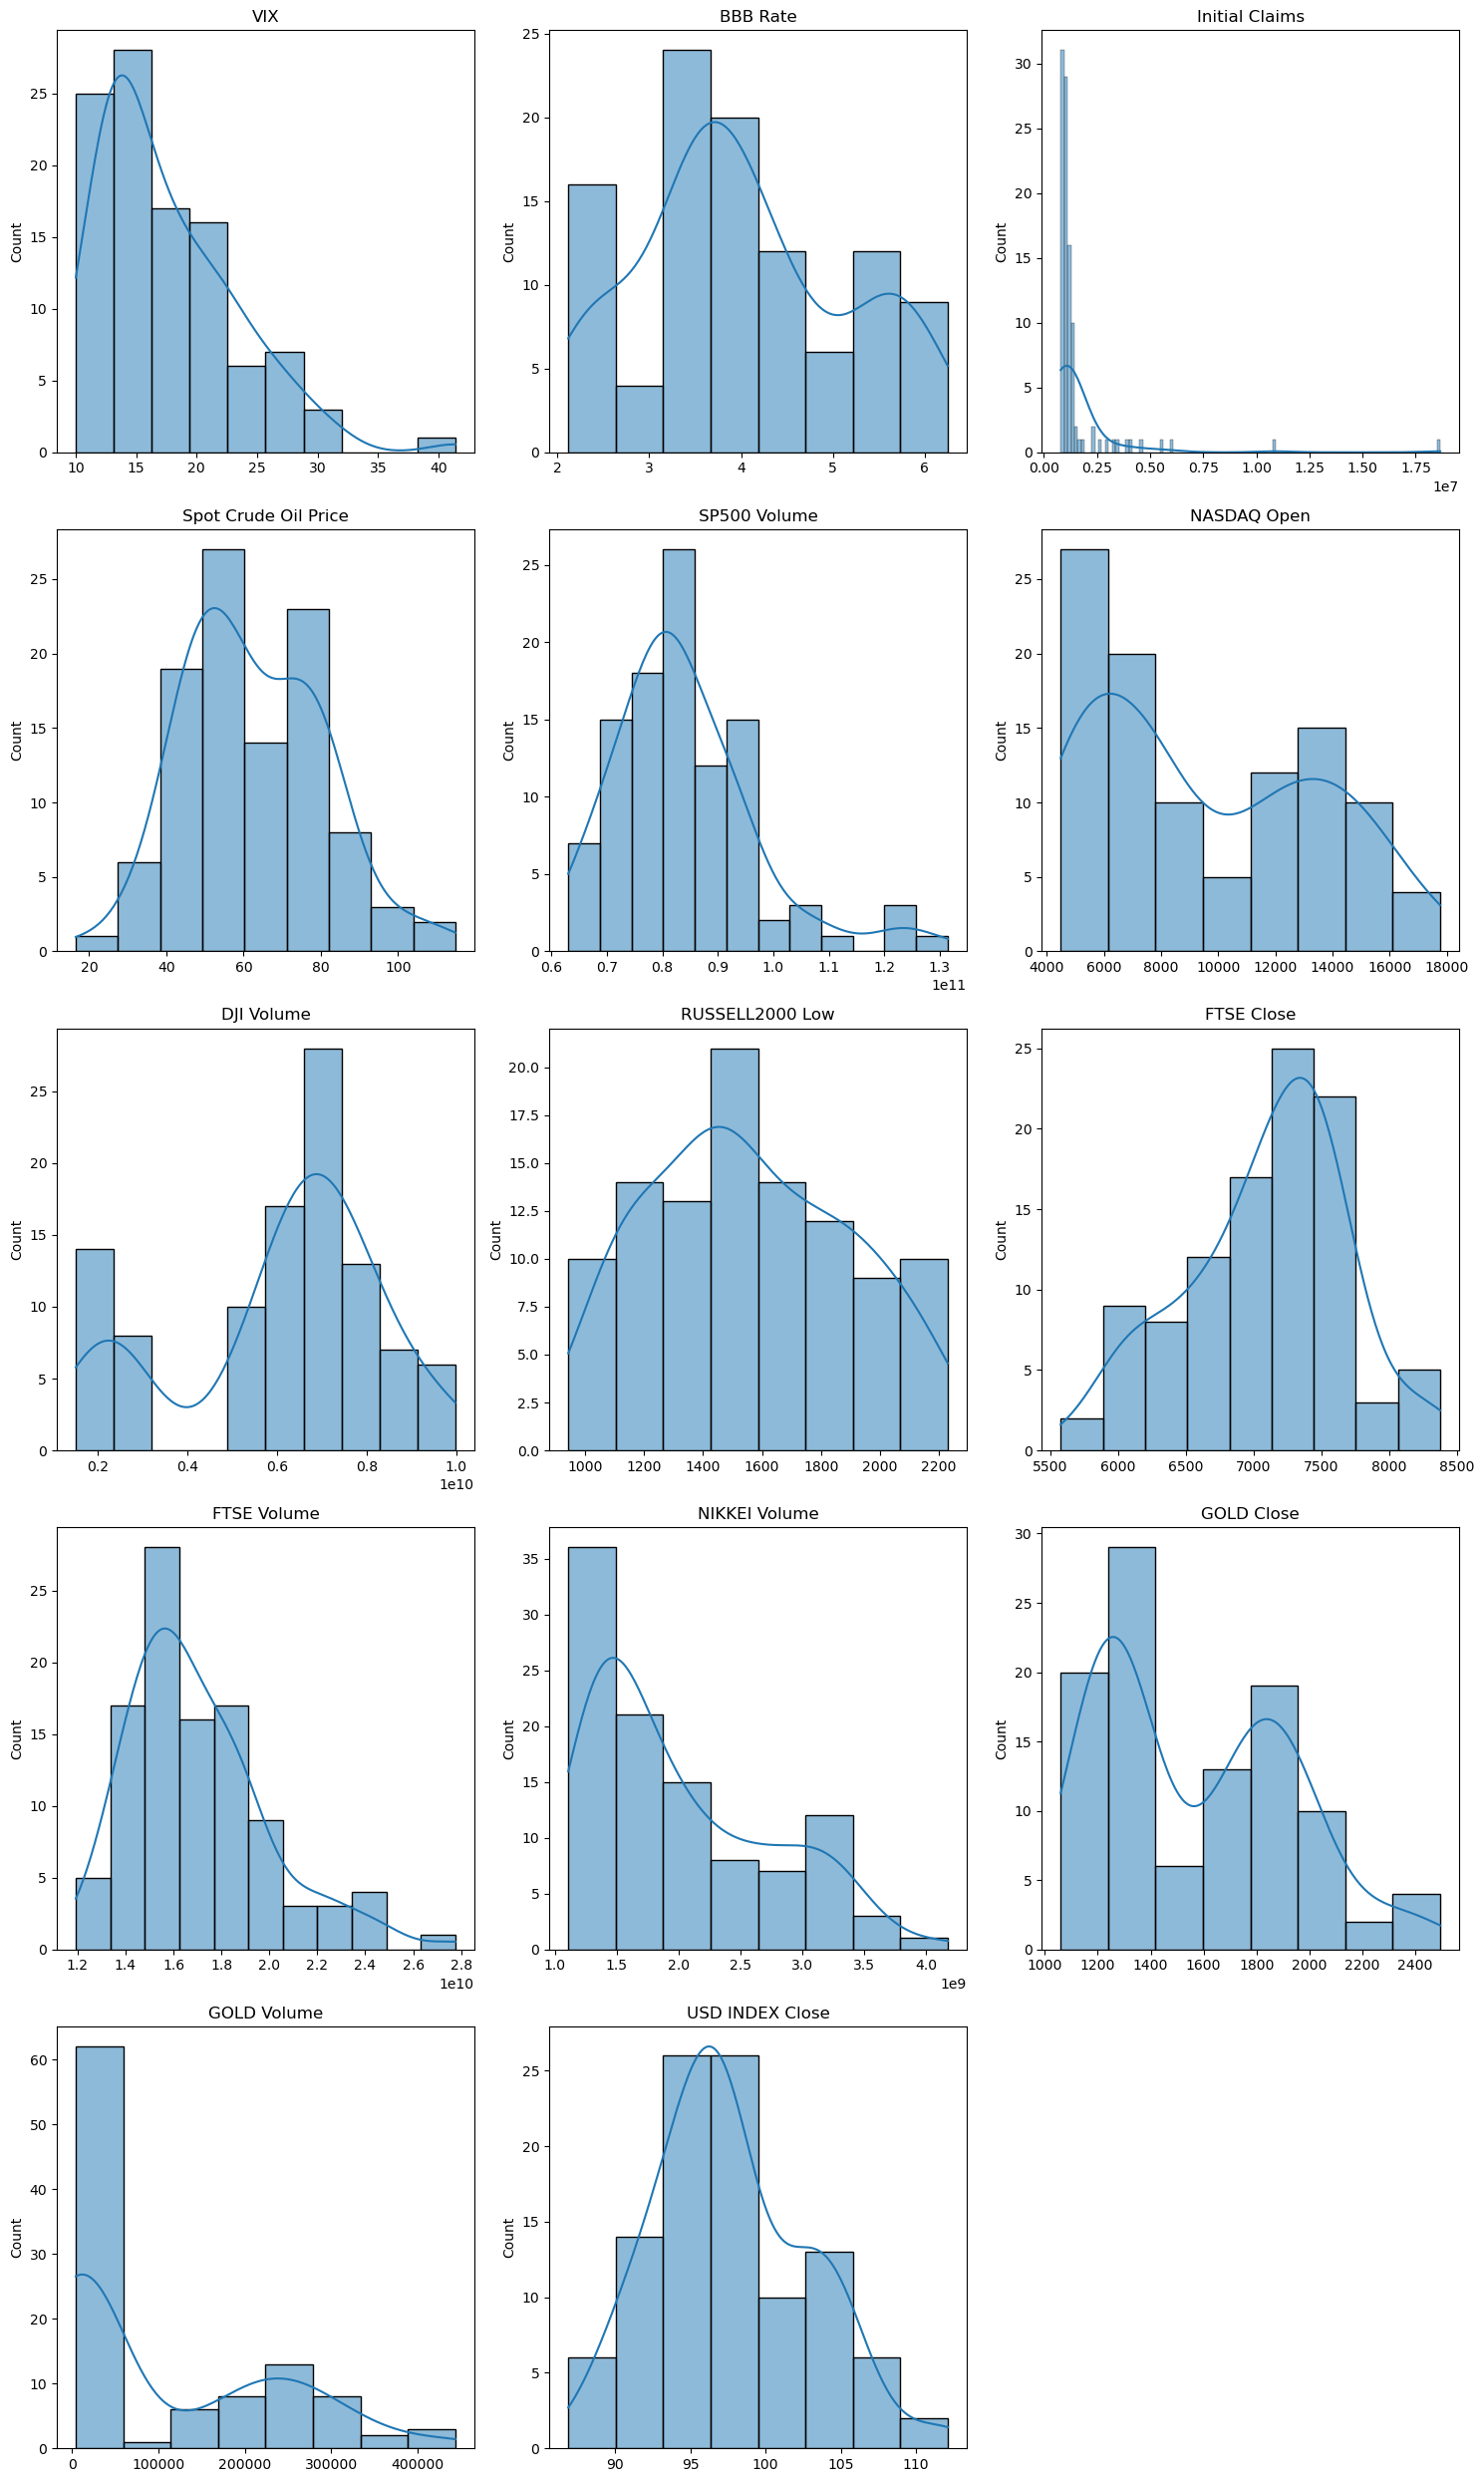

In [117]:
# plt.style.use('seaborn')

n_cols = 3
n_rows = (len(data_clean.columns)-1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
# fig.suptitle('Histograms of all Features', fontsize=16)

axes = axes.flatten()

for i, column in enumerate(data_clean.columns):
    sns.histplot(data=data_clean, x=column, kde=True, bins='auto', ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

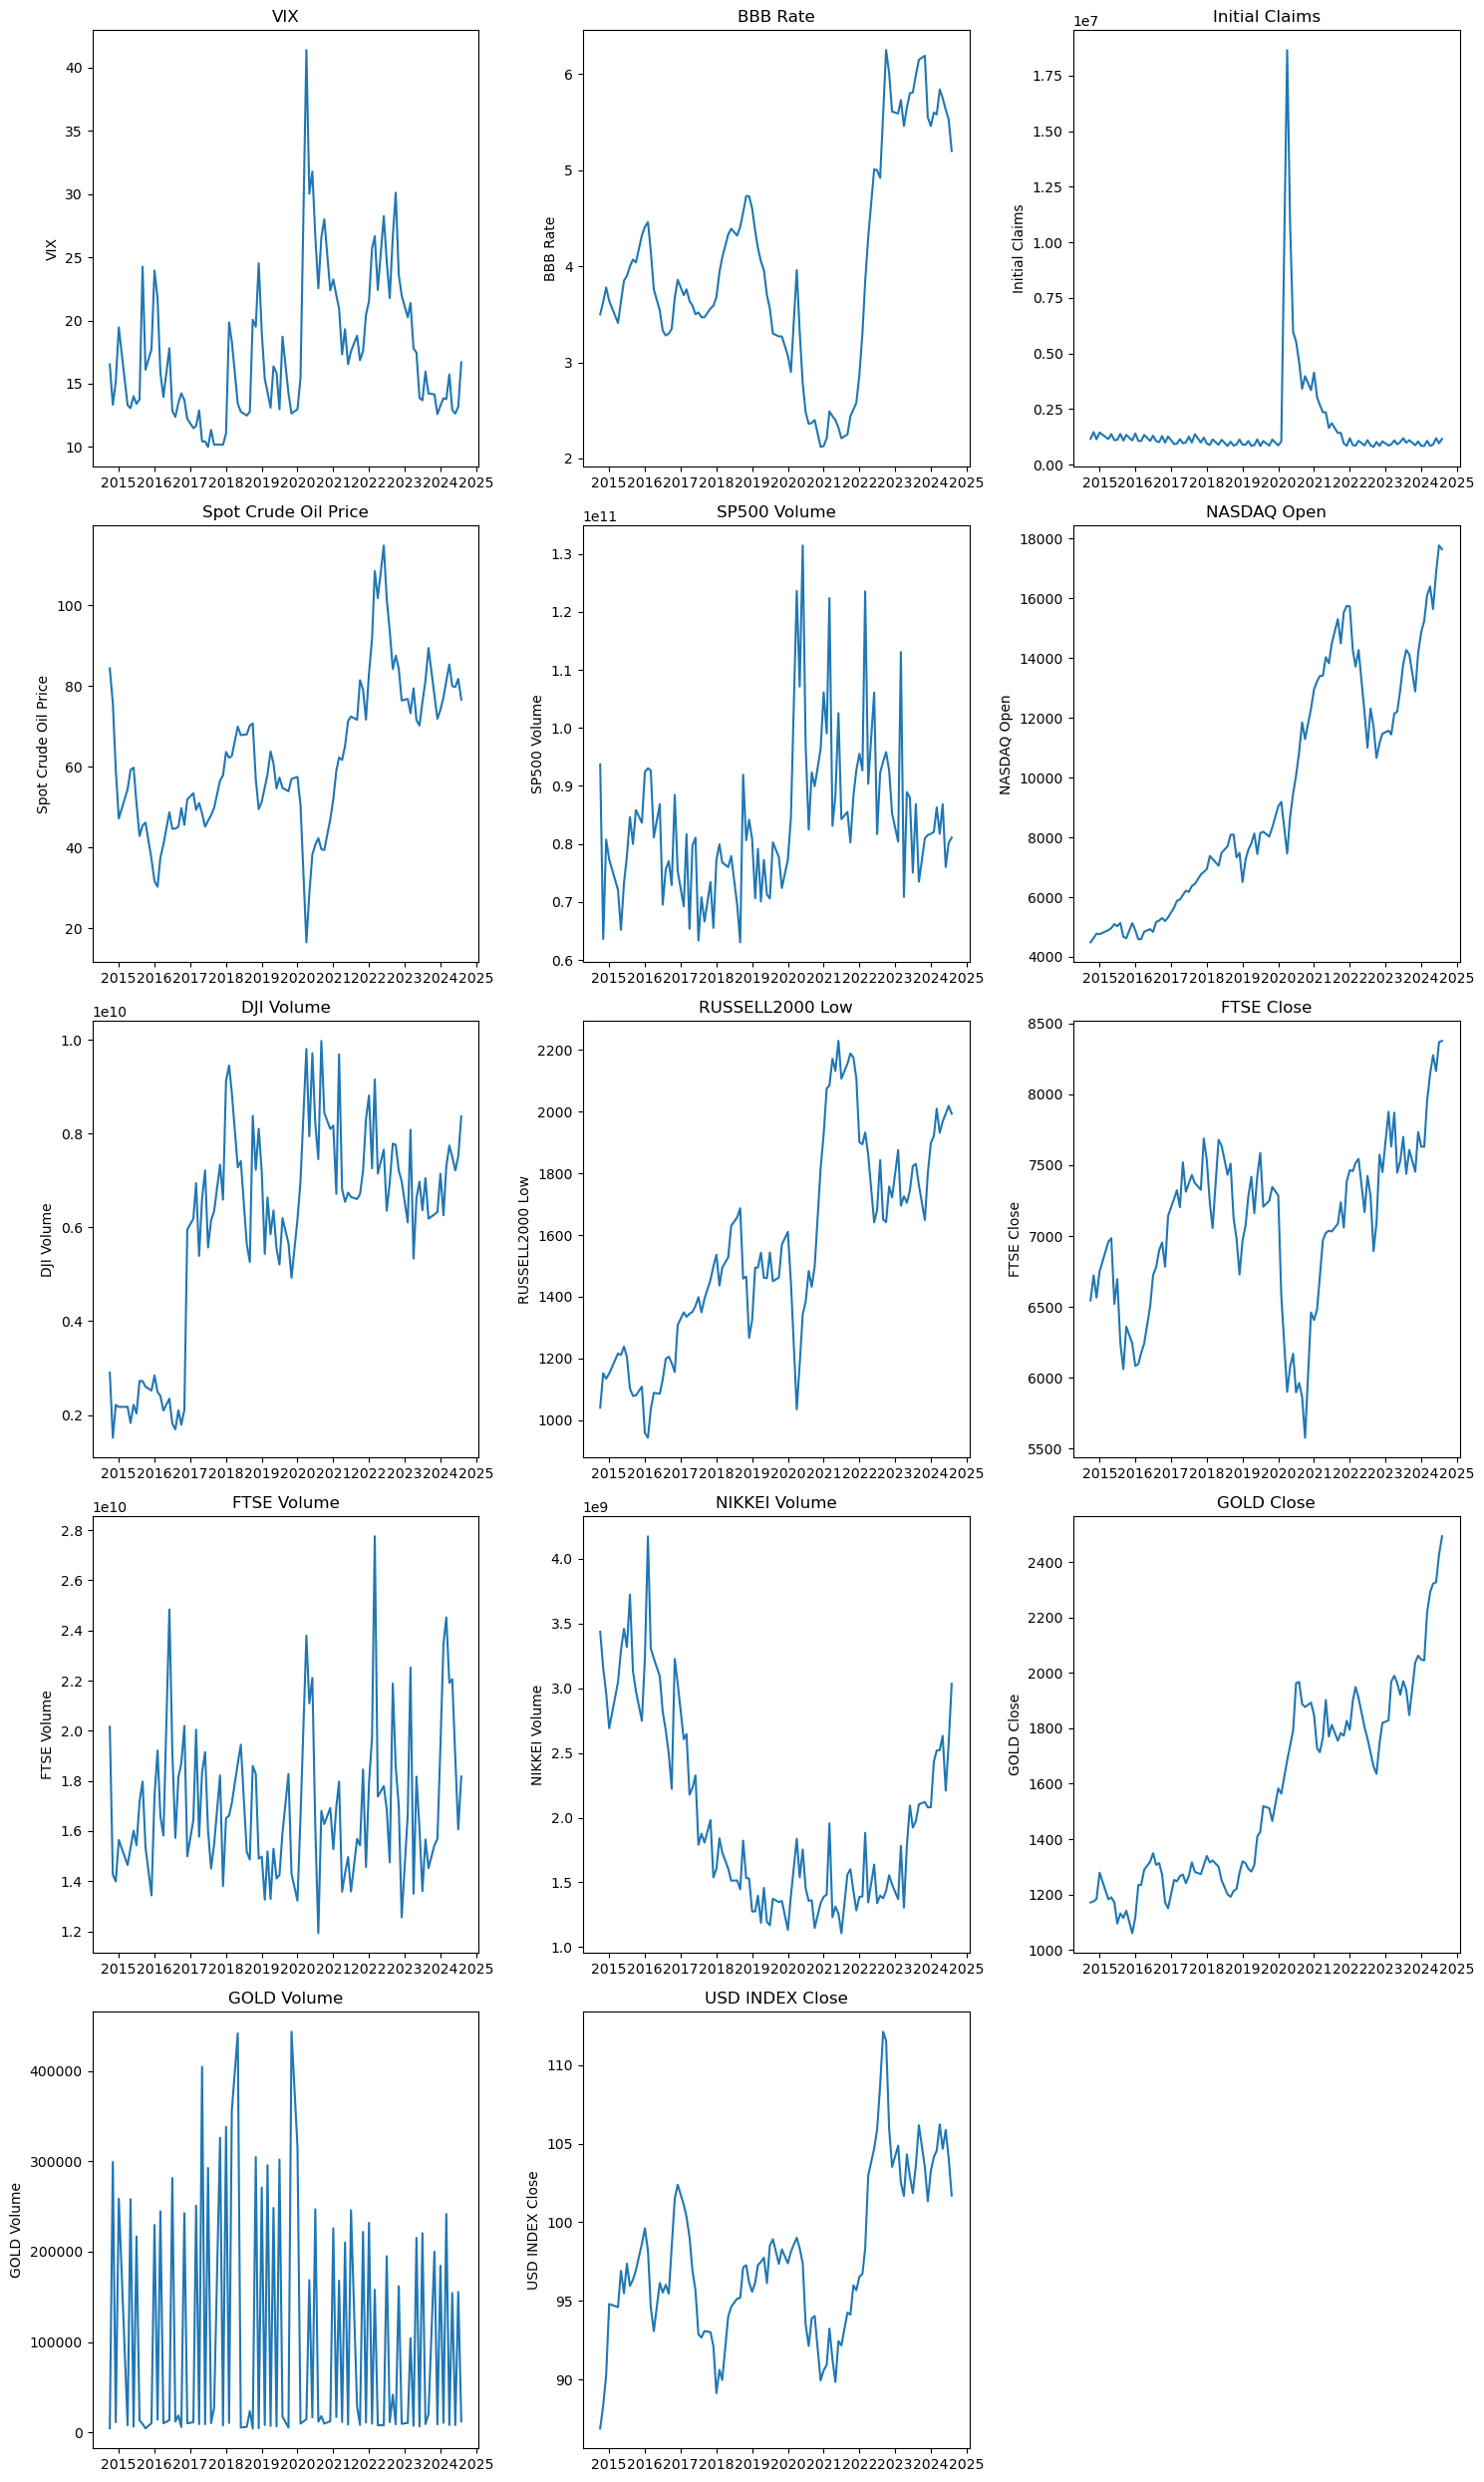

In [118]:
n_cols = 3
n_rows = (len(data_clean.columns)-1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
# fig.suptitle('All Features', fontsize=16)

axes = axes.flatten()

for i, column in enumerate(data_clean.columns):
    sns.lineplot(data=data_clean, x=data_clean.index, y=column, ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [46]:
#Rolling statistics

def calculate_rolling_stats(df, window):
    rolling_mean = df.rolling(window=window).mean()
    rolling_std = df.rolling(window=window).std()
    return rolling_mean, rolling_std

In [47]:

window_size = 6

rolling_mean, rolling_std = calculate_rolling_stats(data_clean, window=window_size)

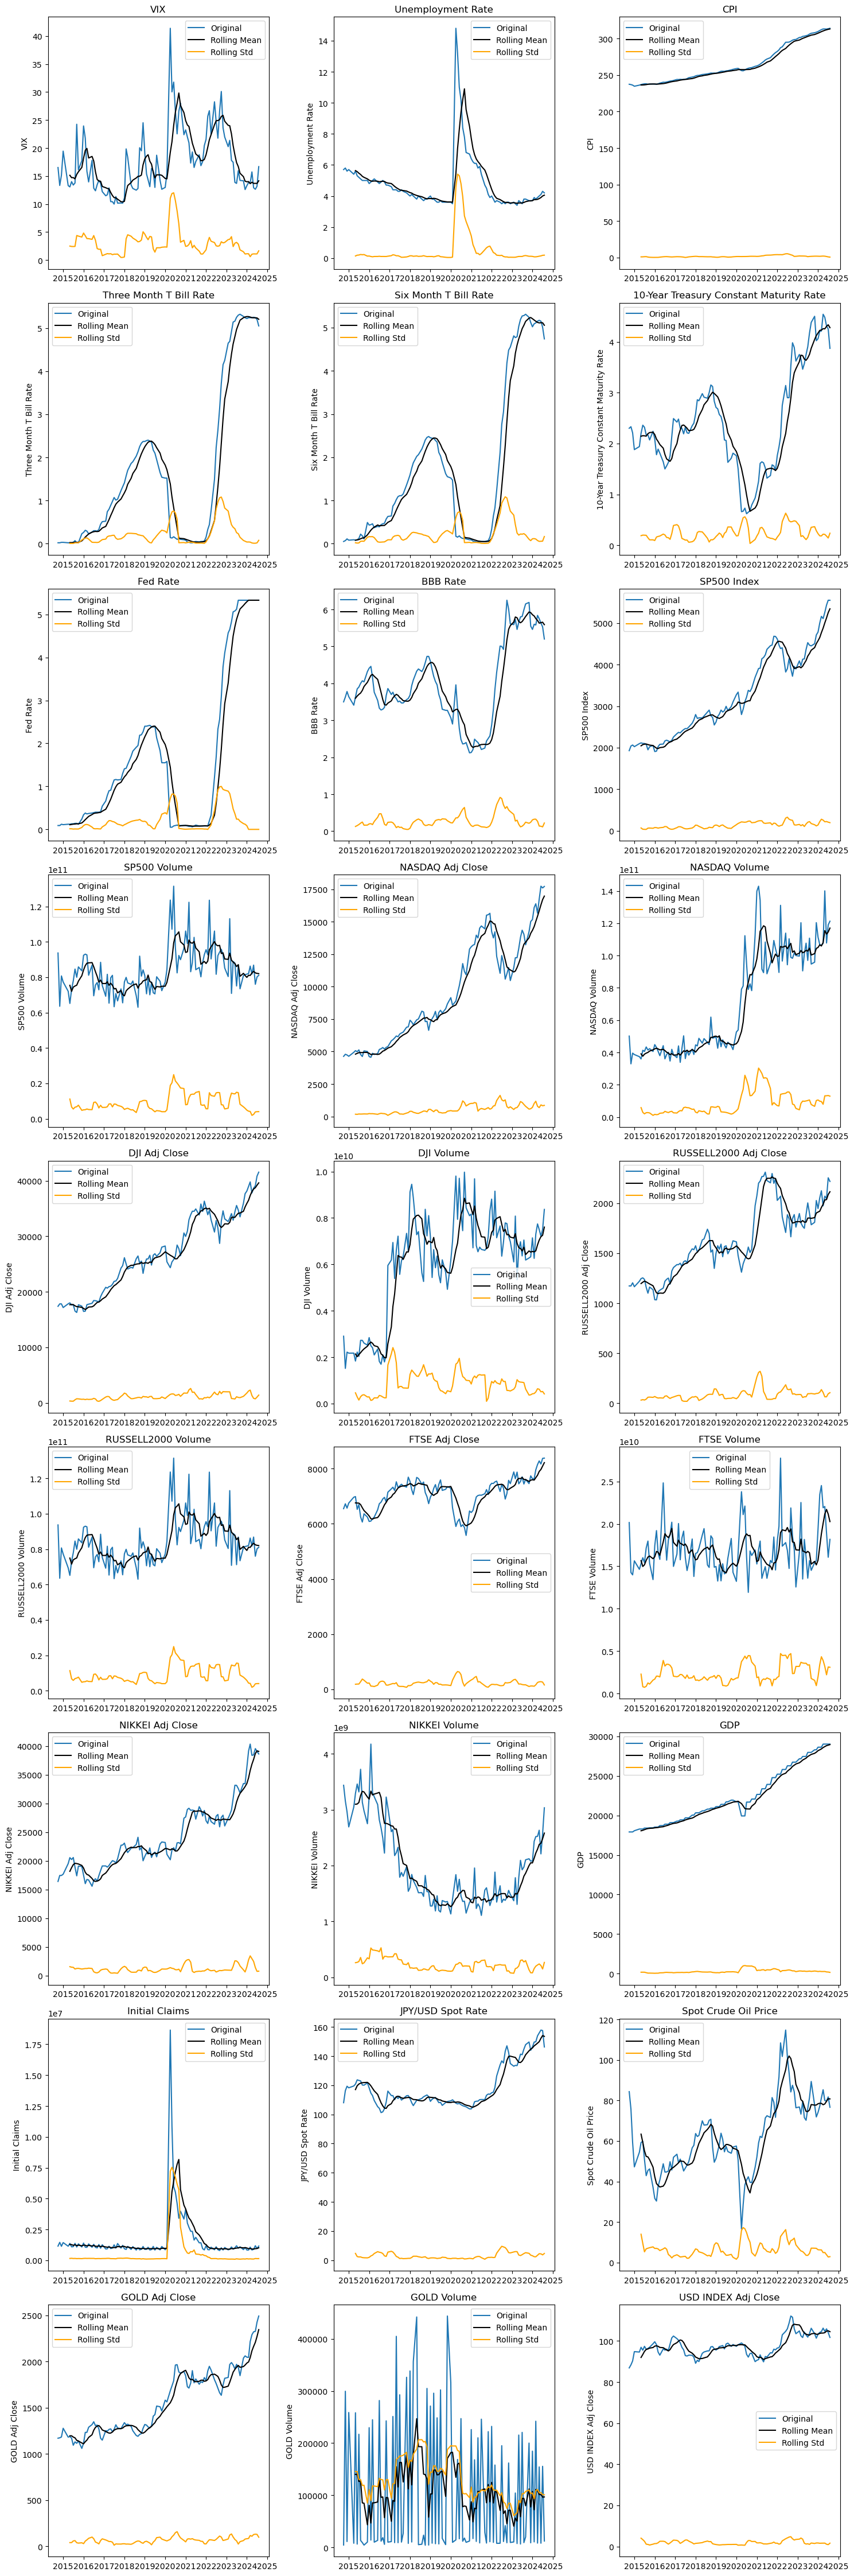

In [48]:

n_cols = 3
n_rows = (len(data_clean.columns)-1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for i, column in enumerate(data_clean.columns):
    sns.lineplot(data=data_clean, x=data_clean.index, y=column, label='Original', ax=axes[i])
    sns.lineplot(data=rolling_mean, x=rolling_mean.index, y=rolling_mean[column], color='black', label='Rolling Mean', ax=axes[i])
    sns.lineplot(data=rolling_std, x=rolling_std.index, y=rolling_std[column], color='orange', label='Rolling Std', ax=axes[i])
    axes[i].legend(loc='best')
    axes[i].set_title(column)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [119]:
#Decompose

def decompose_and_plot(series, column, period):
    decomposition = seasonal_decompose(series, model='additive', period=period)

    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 3)
    
    fig.suptitle(column, fontsize=20)
    

    #Plot original data
    ax_original = fig.add_subplot(gs[0, :])
    ax_original.plot(series)
    ax_original.set_title('Original')
    ax_original.set_xlabel('')

    #Plot trend
    ax_trend = fig.add_subplot(gs[1, 0])
    ax_trend.plot(decomposition.trend)
    ax_trend.set_title('Trend')

    #Plot seasonal
    ax_seasonal = fig.add_subplot(gs[1, 1])
    ax_seasonal.plot(decomposition.seasonal)
    ax_seasonal.set_title('Seasonal')

    #Plot residual
    ax_residual = fig.add_subplot(gs[1, 2])
    ax_residual.plot(decomposition.resid)
    ax_residual.set_title('Residual')

    plt.tight_layout()
    plt.show()



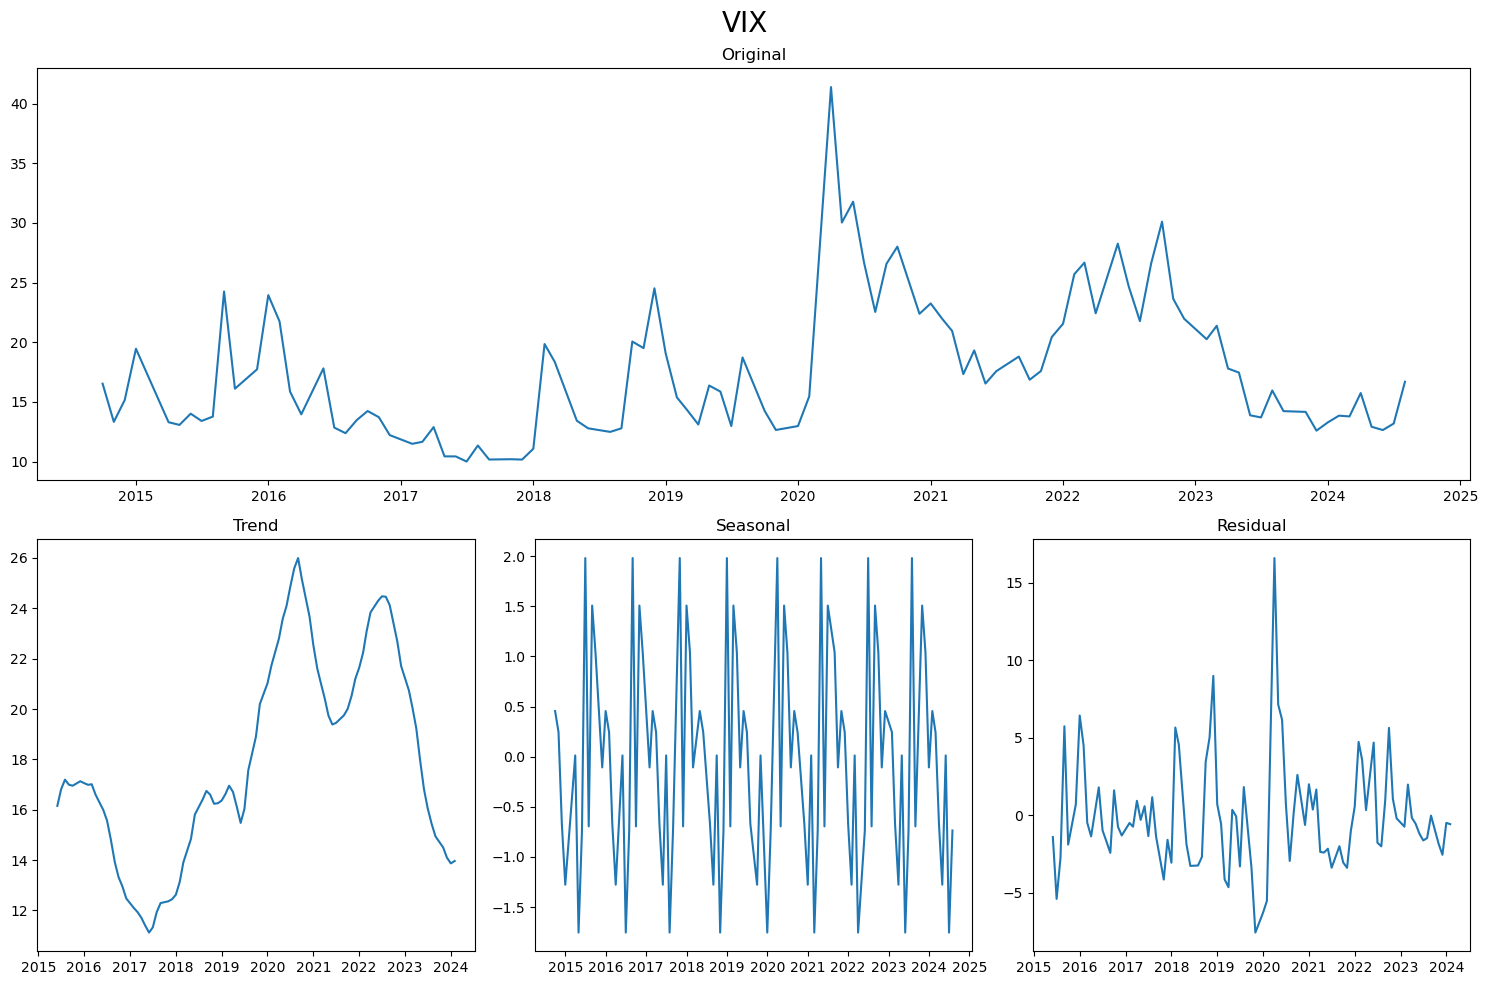

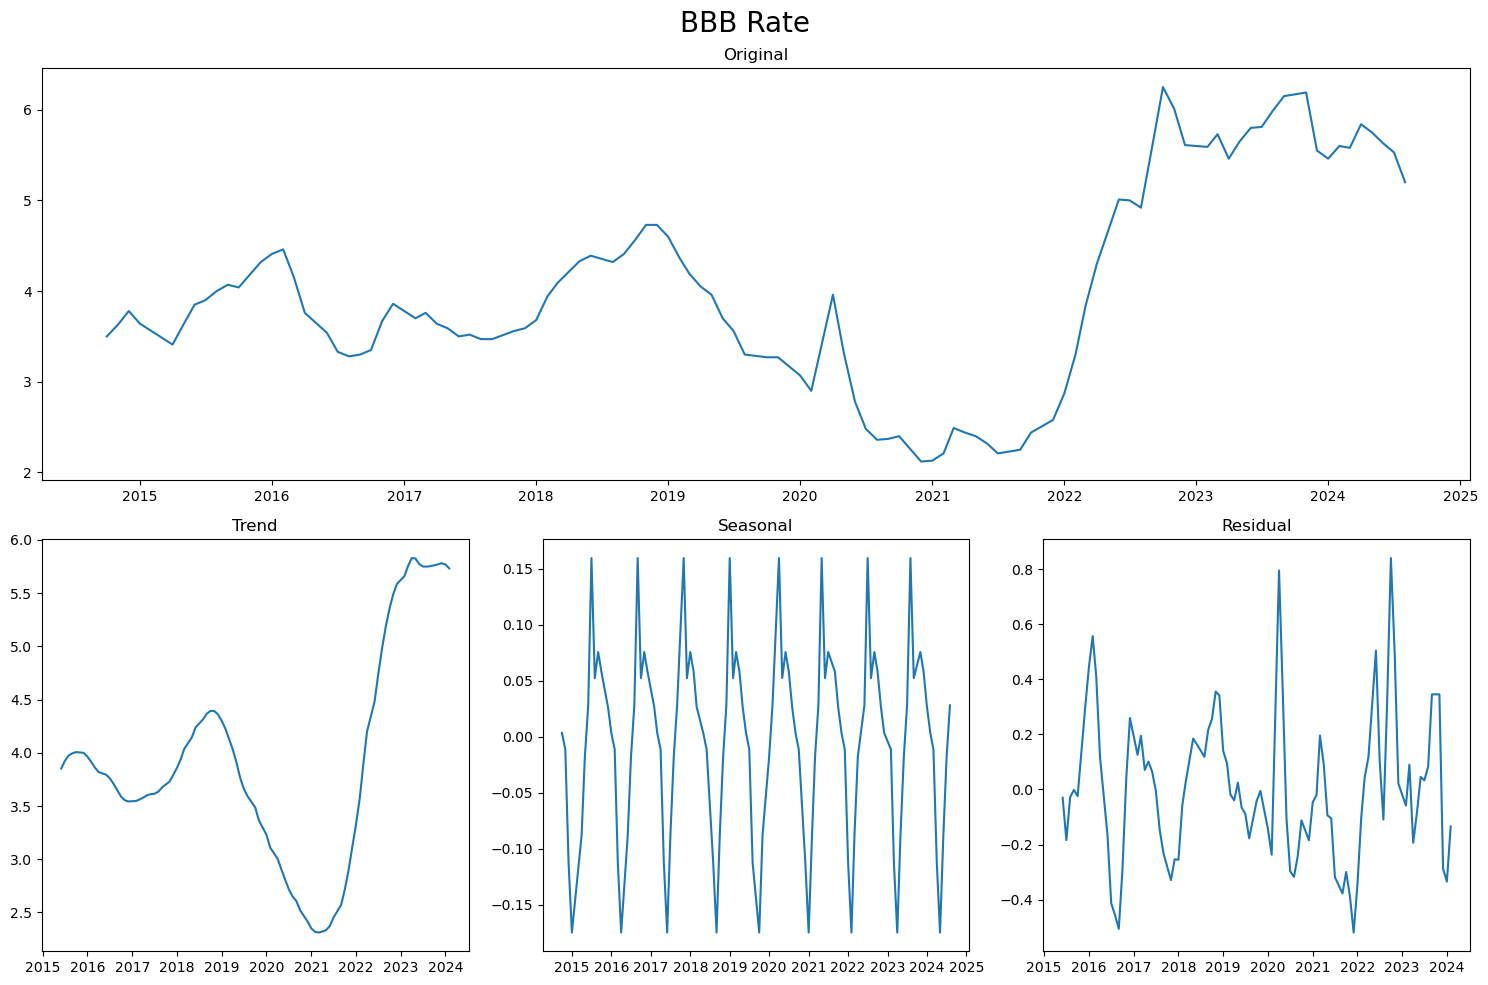

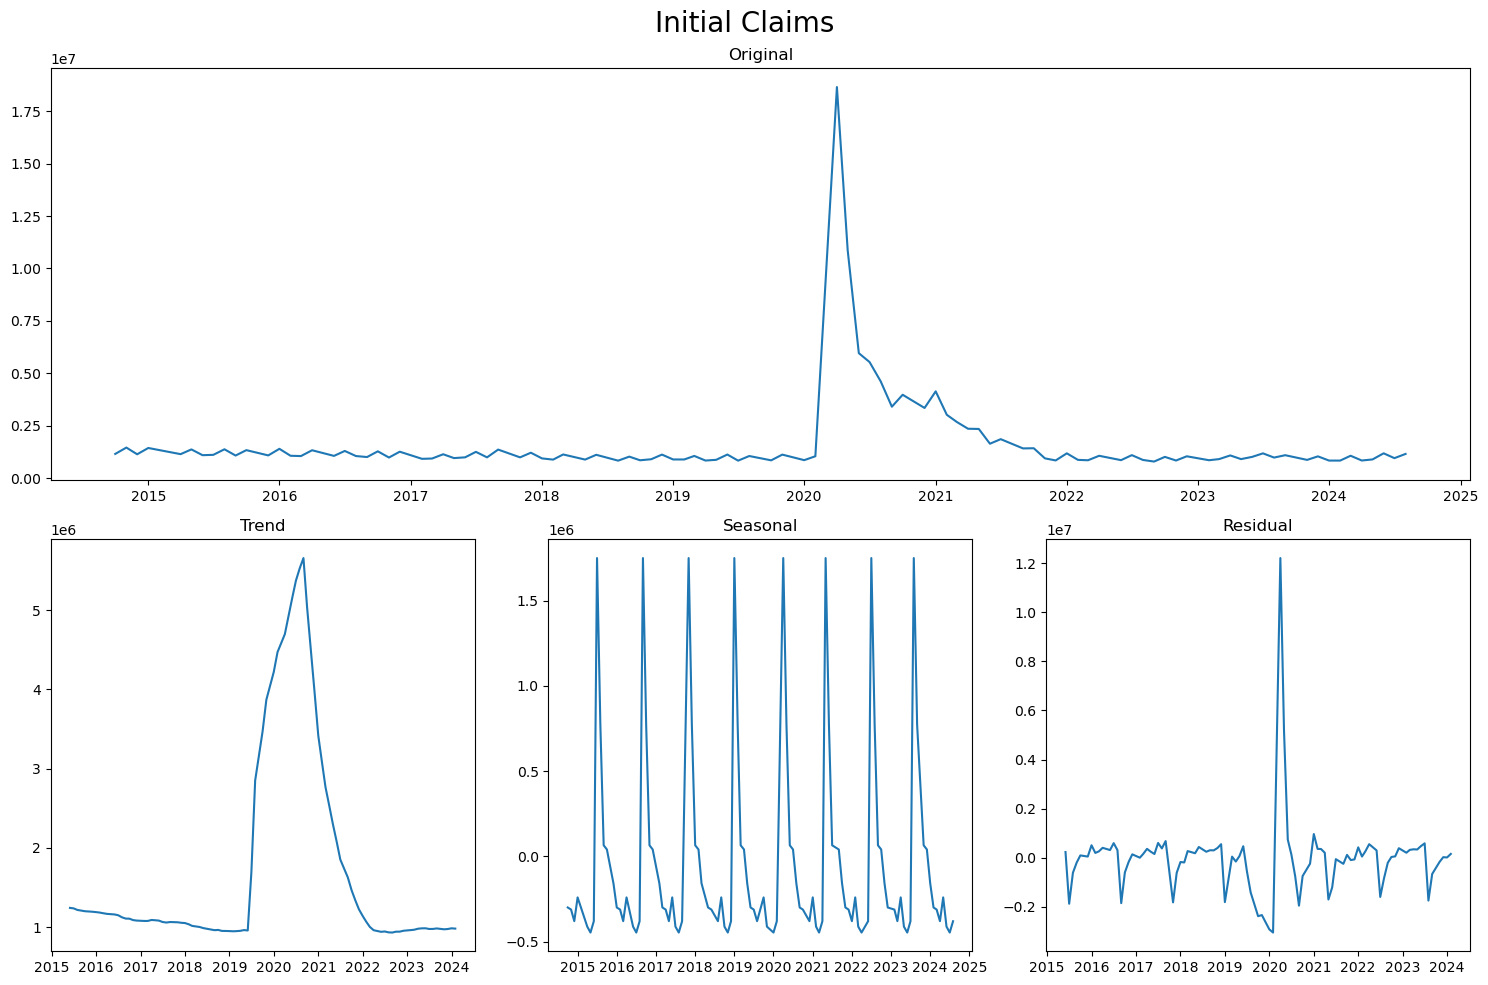

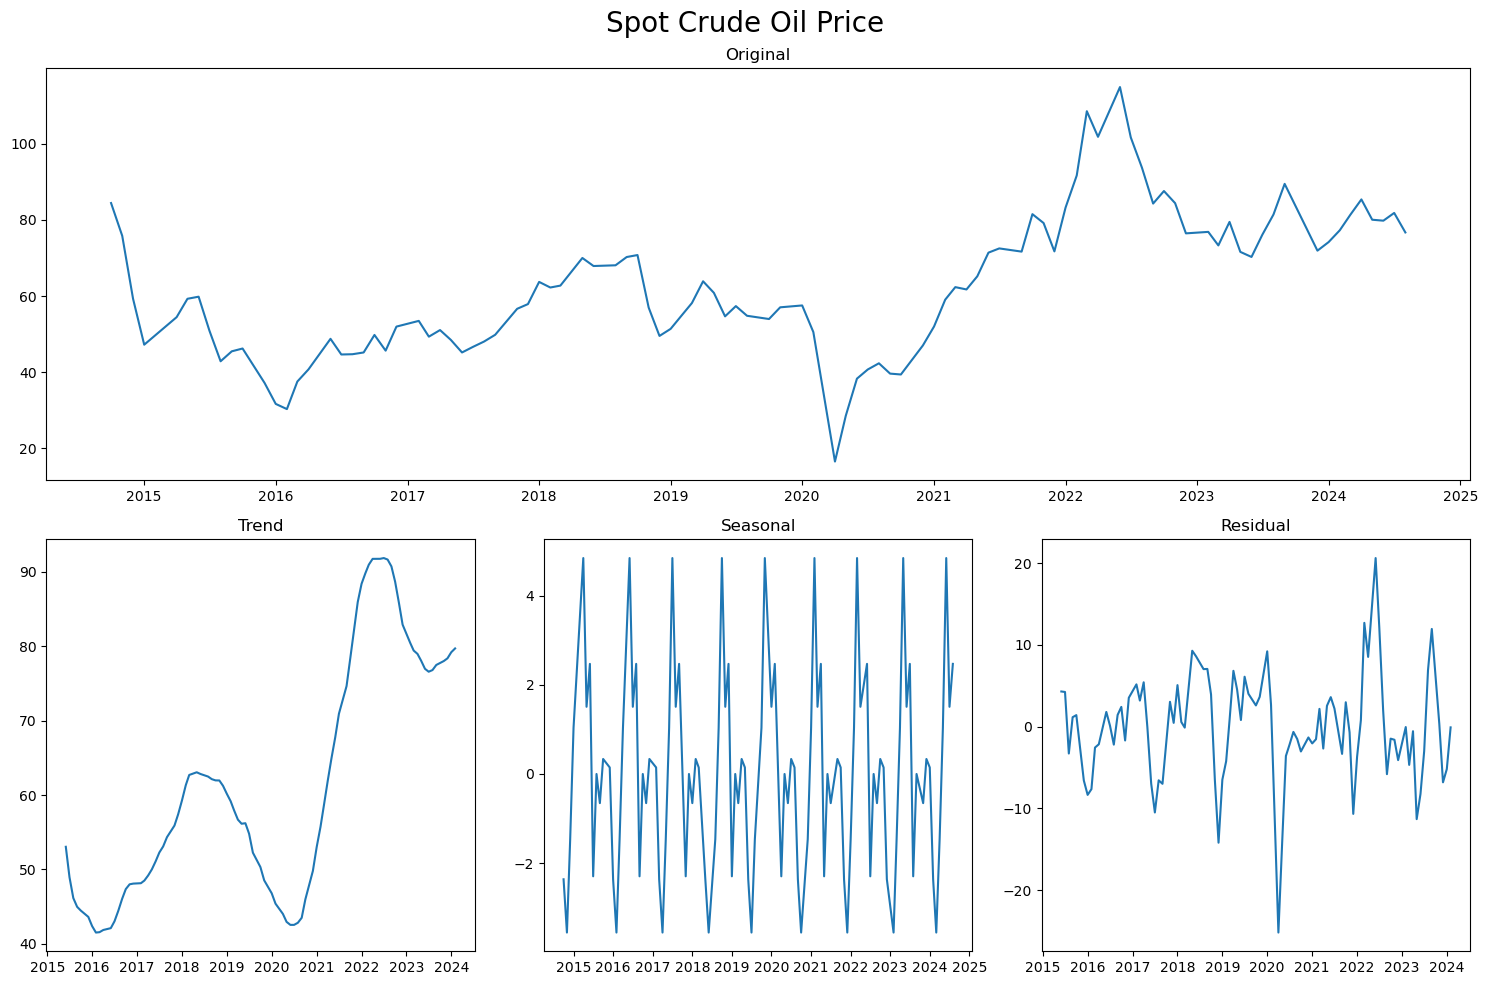

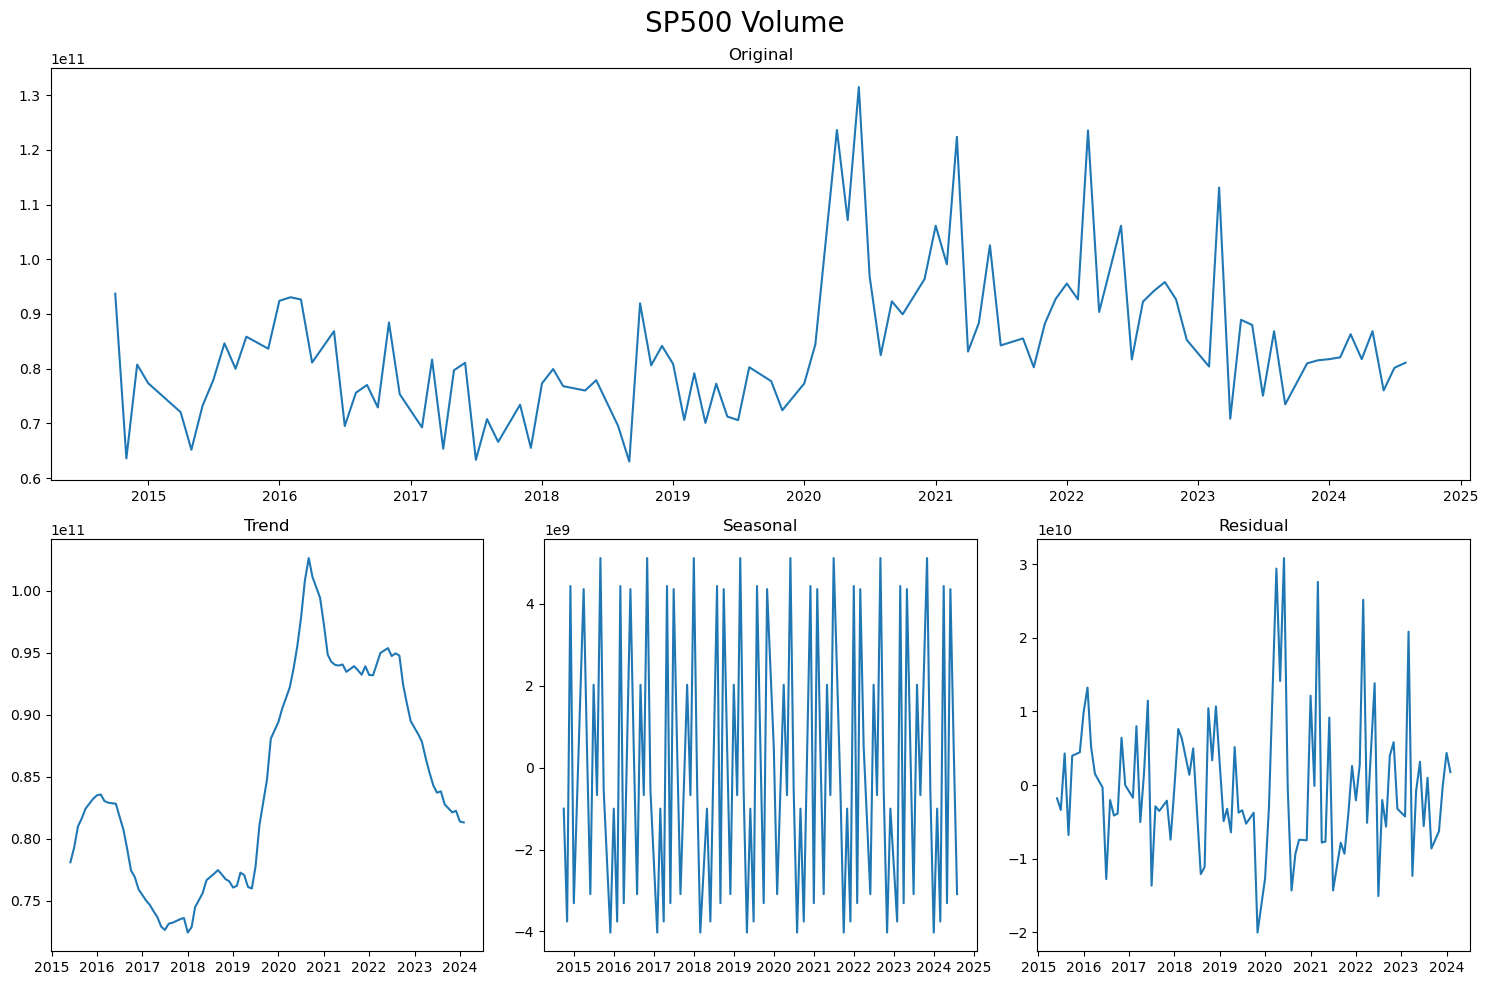

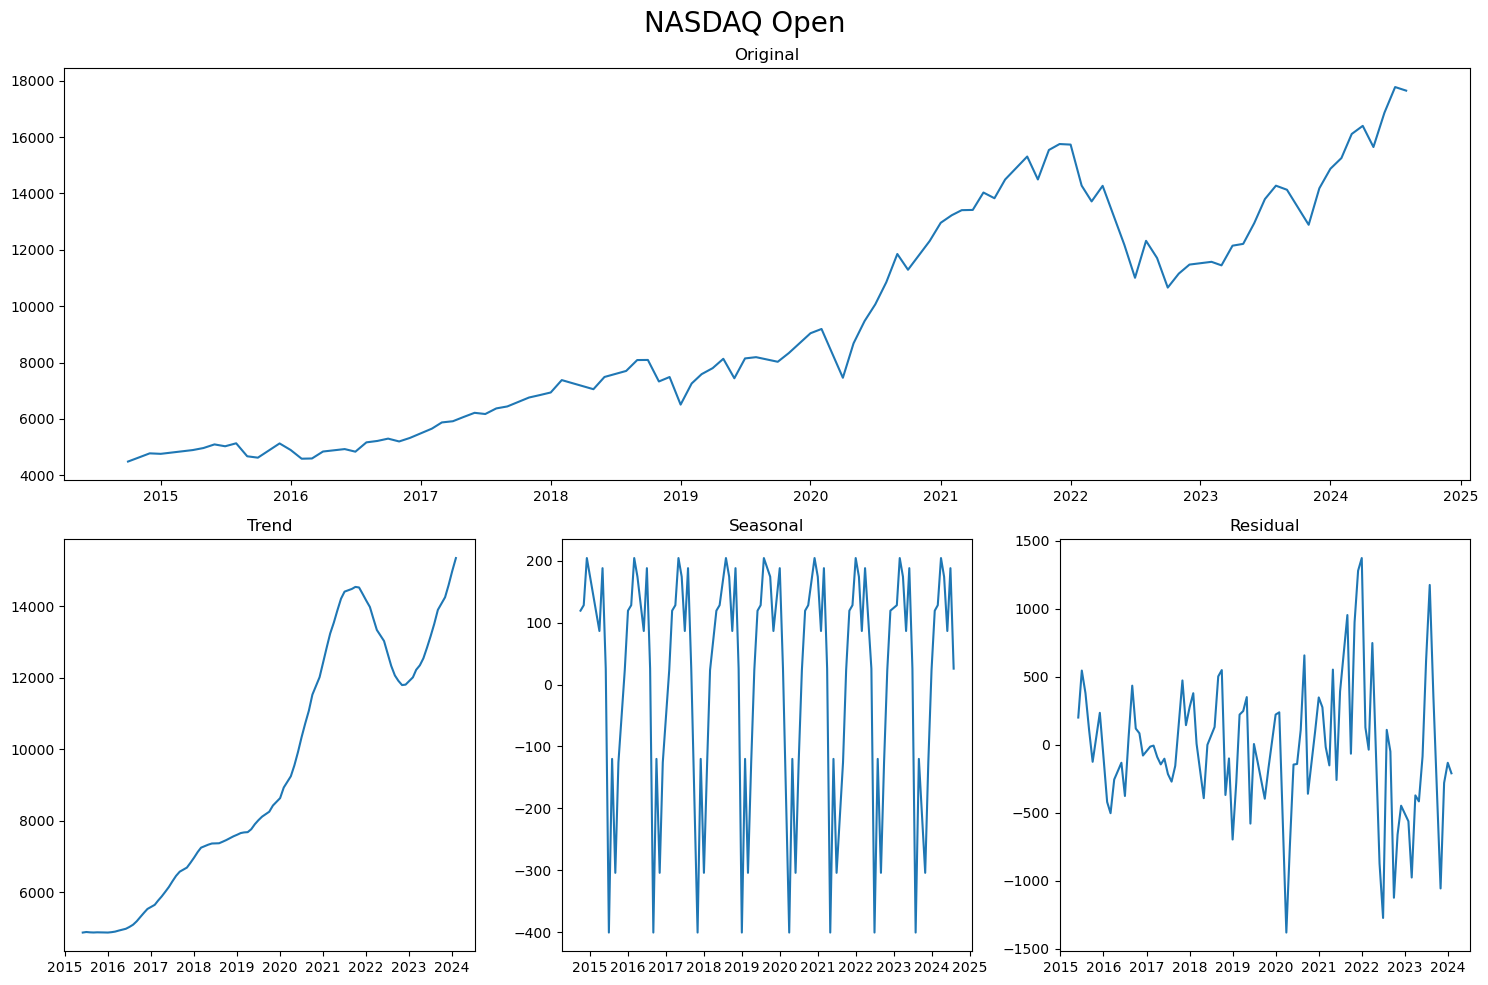

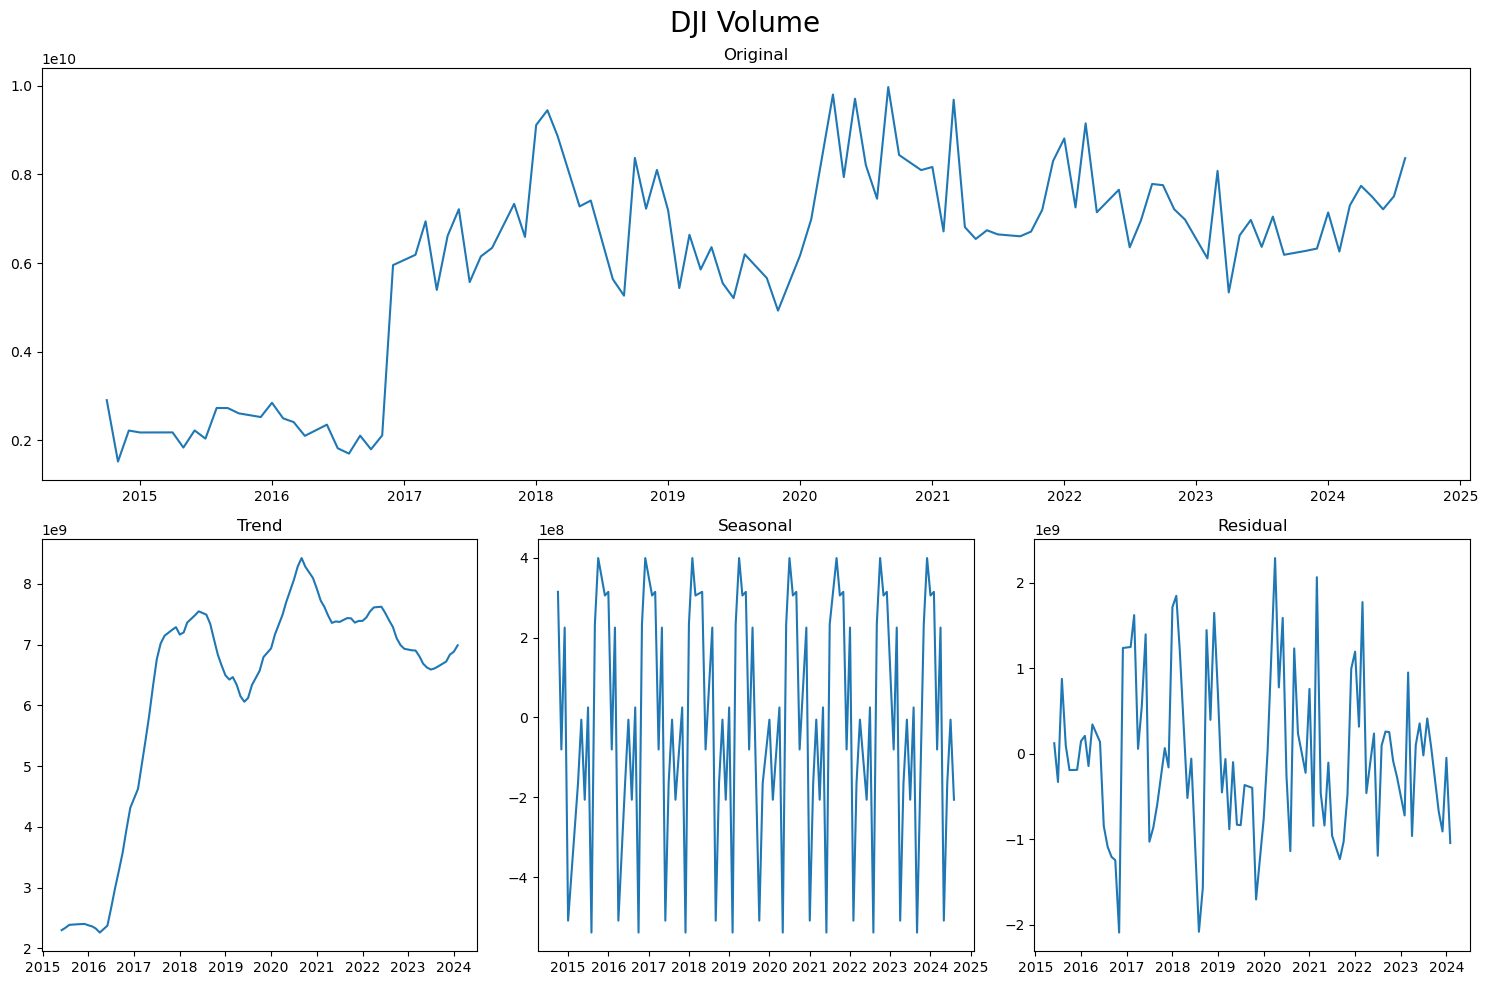

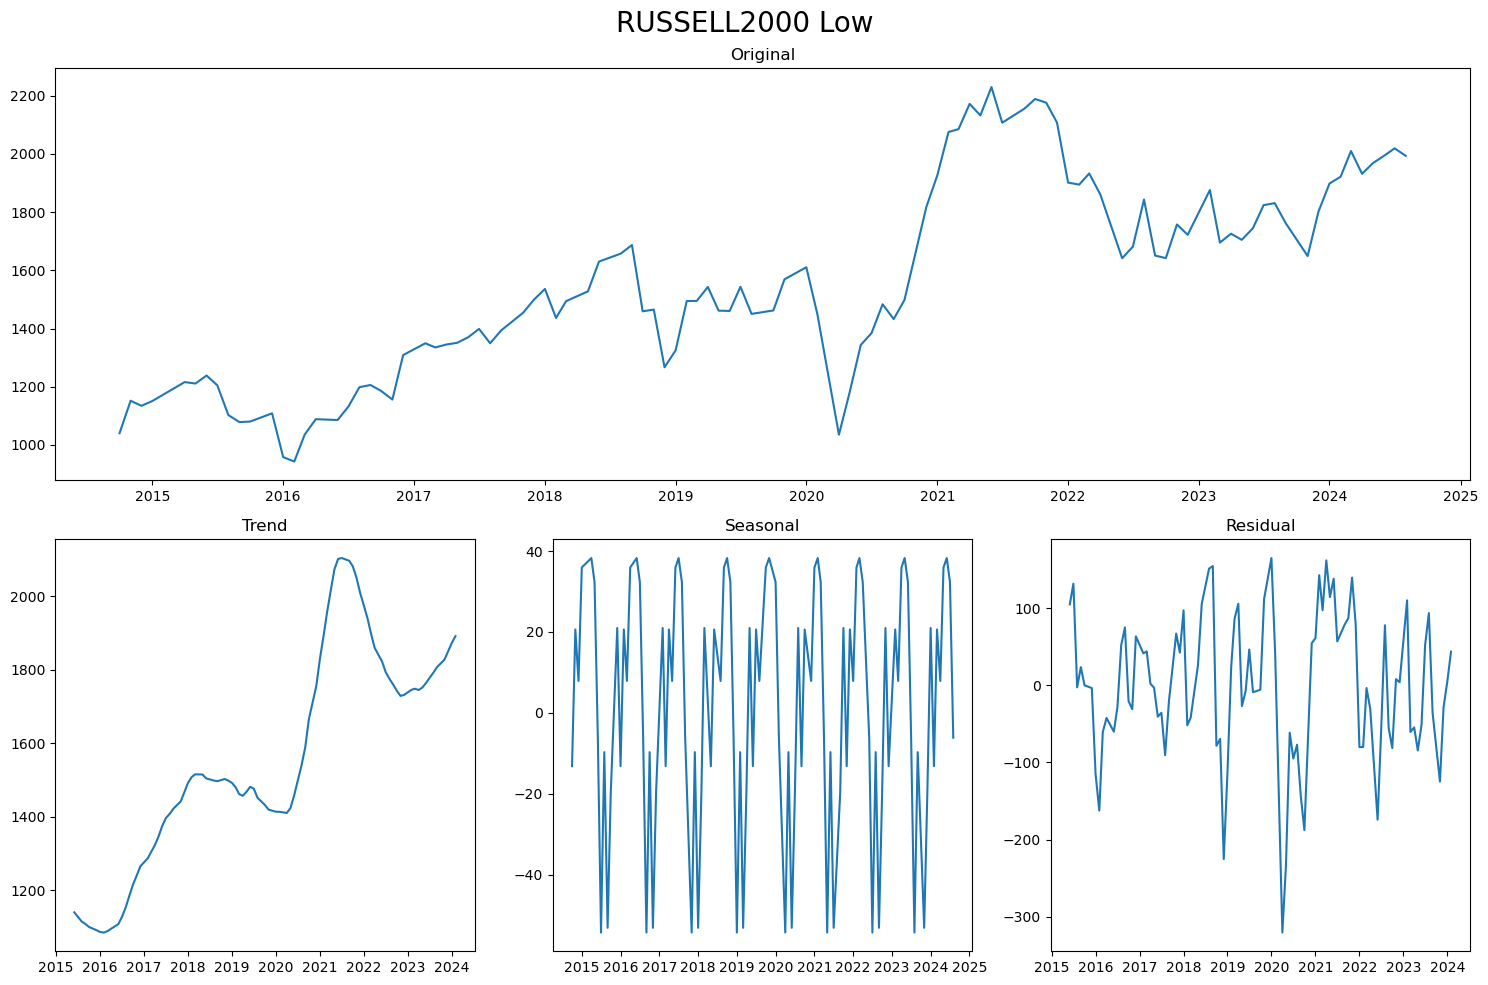

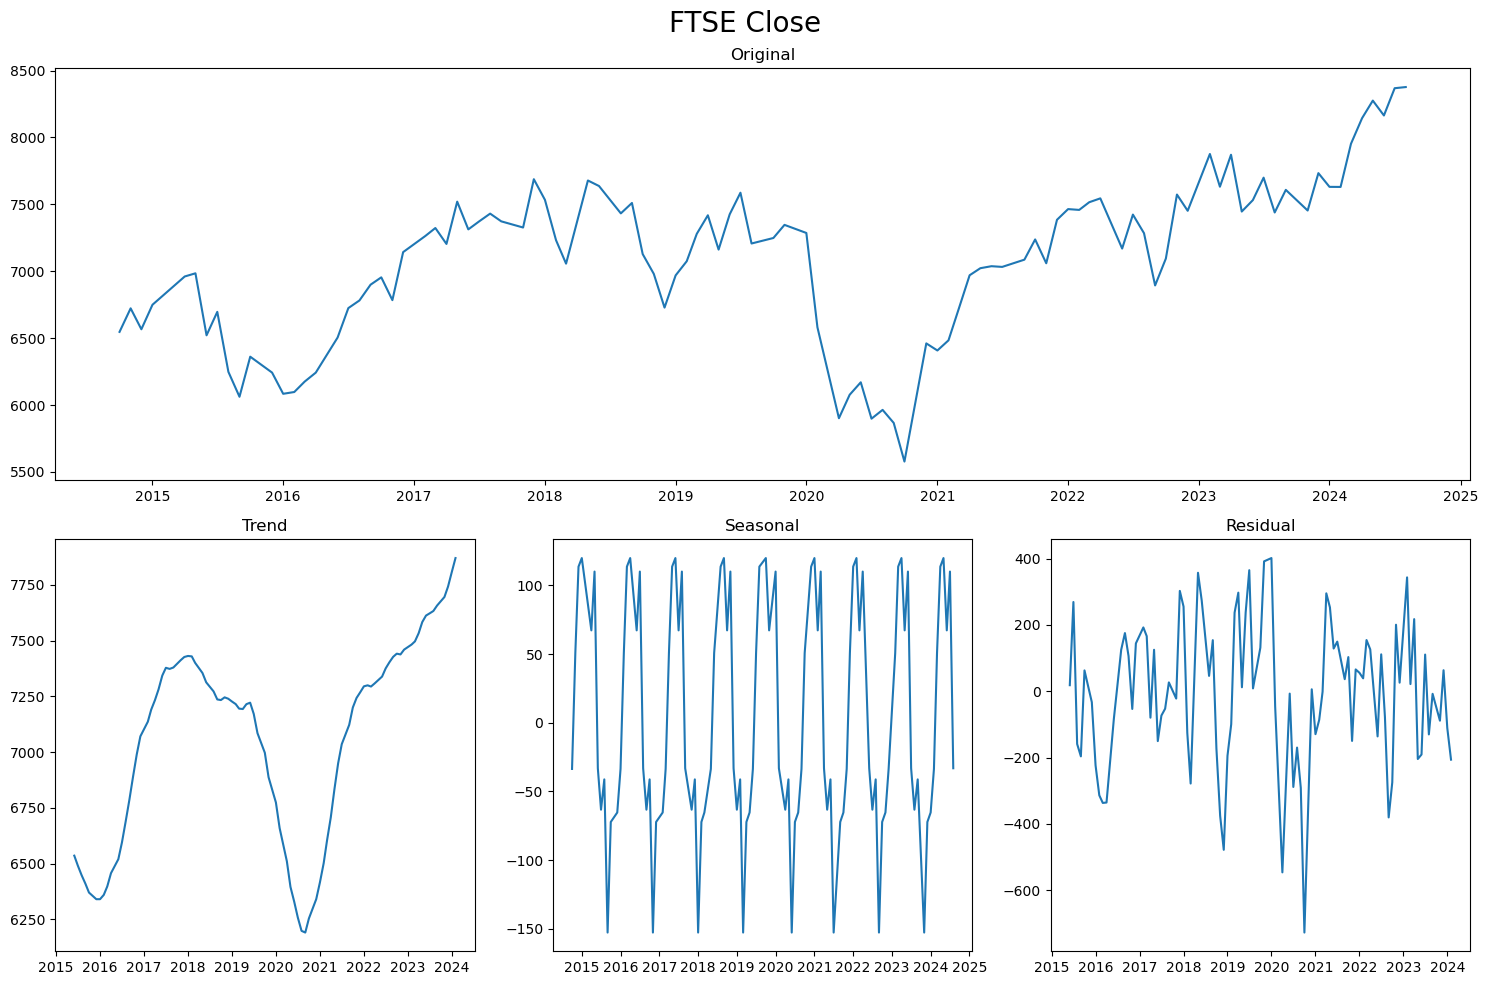

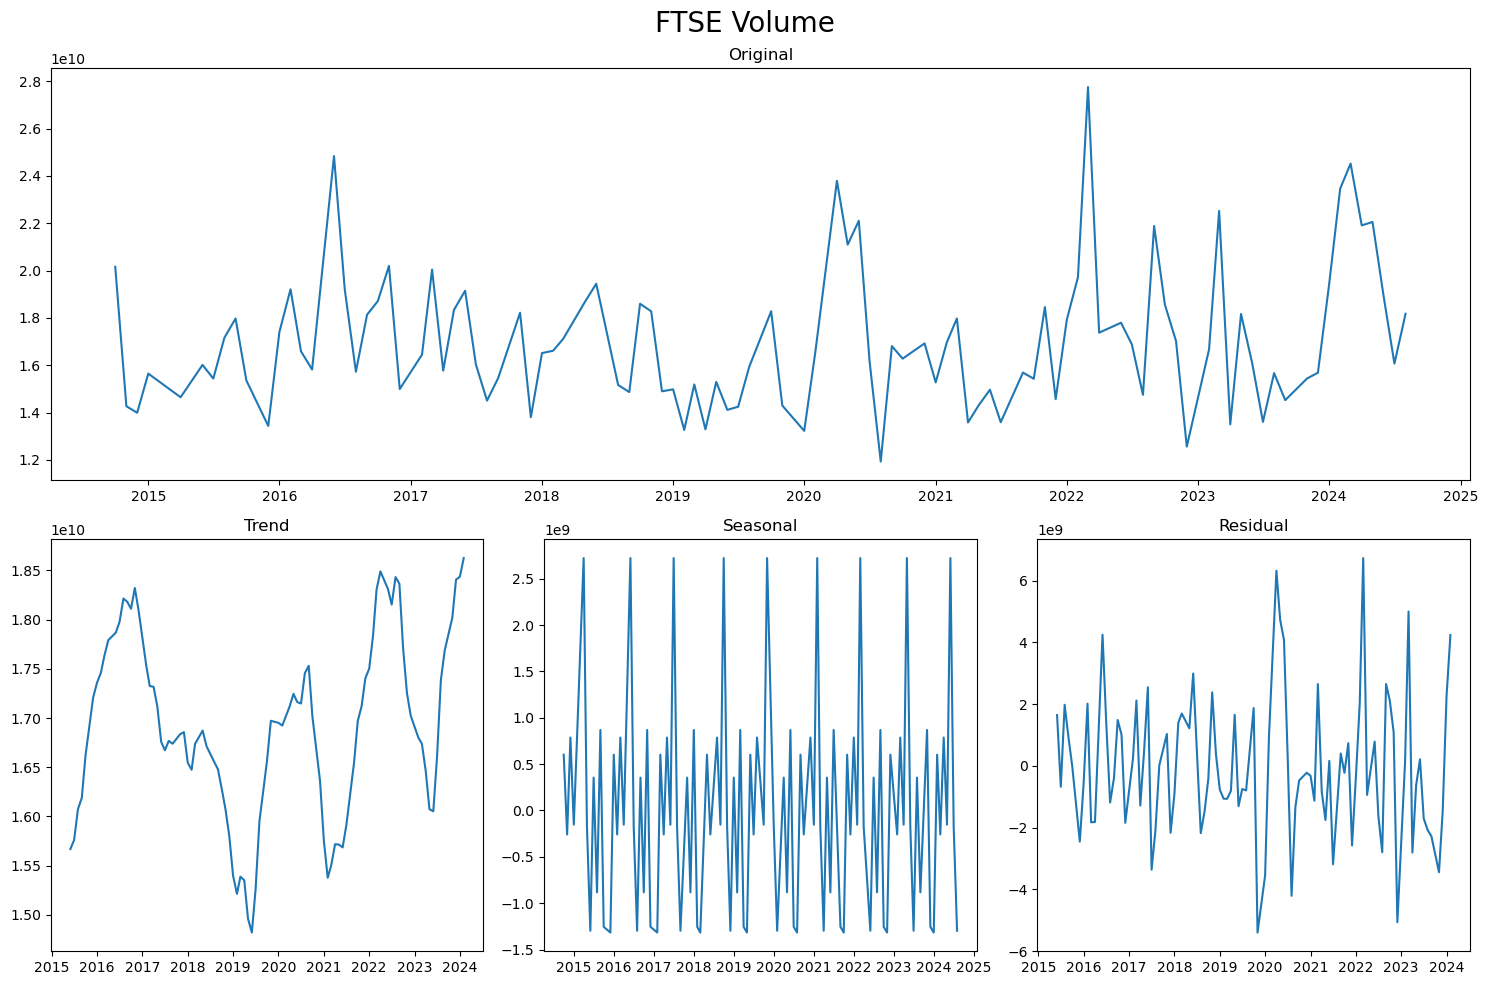

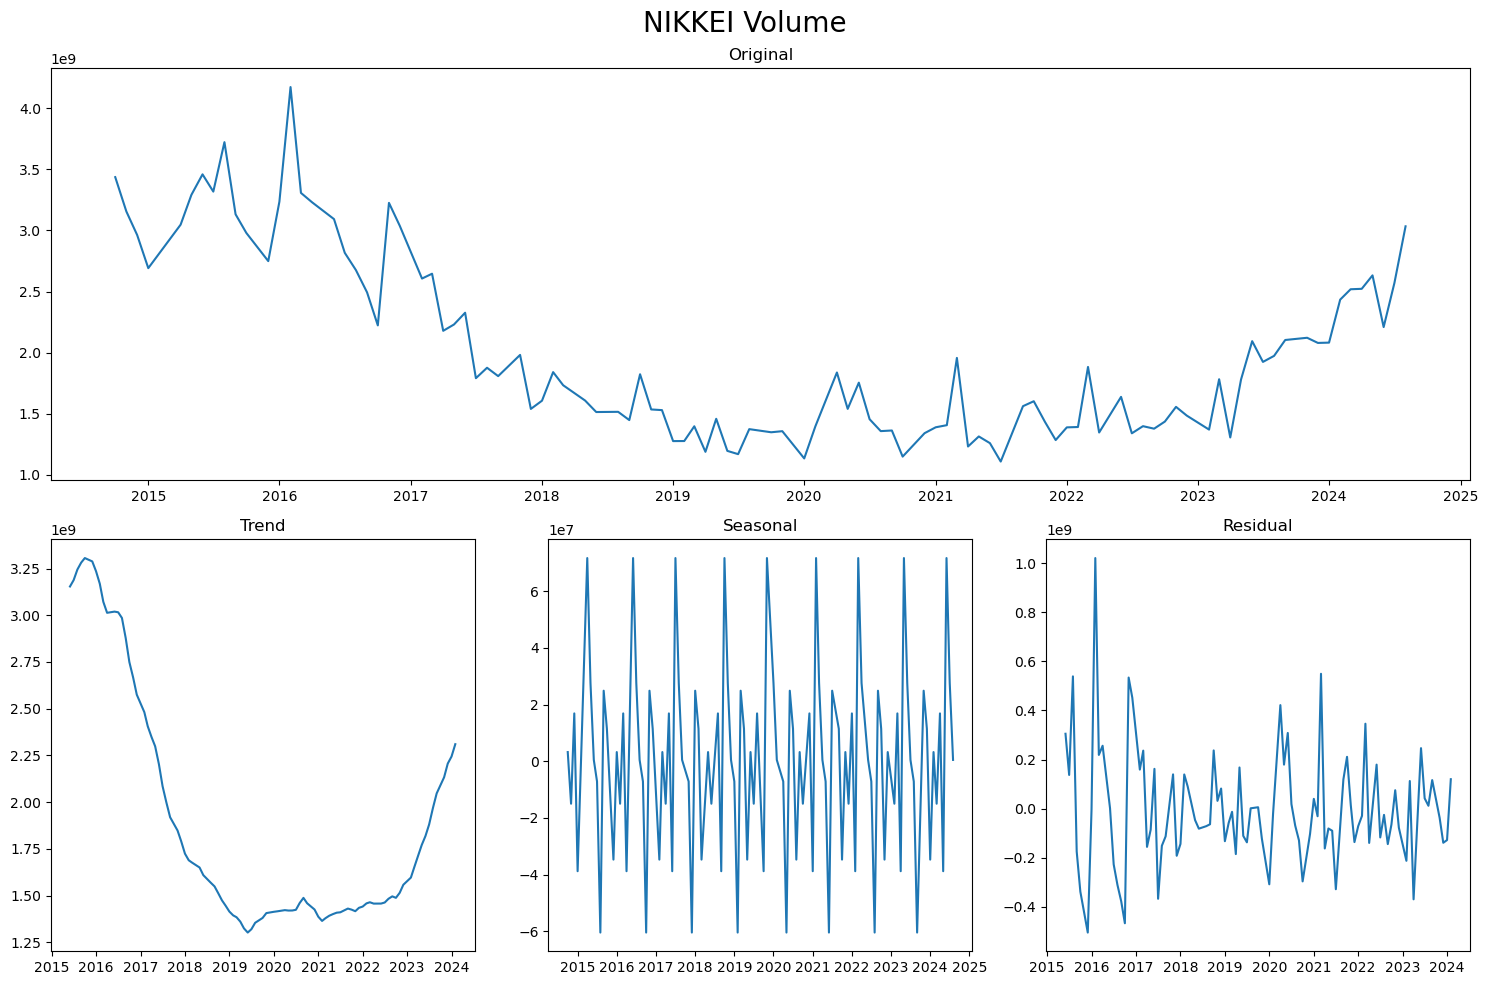

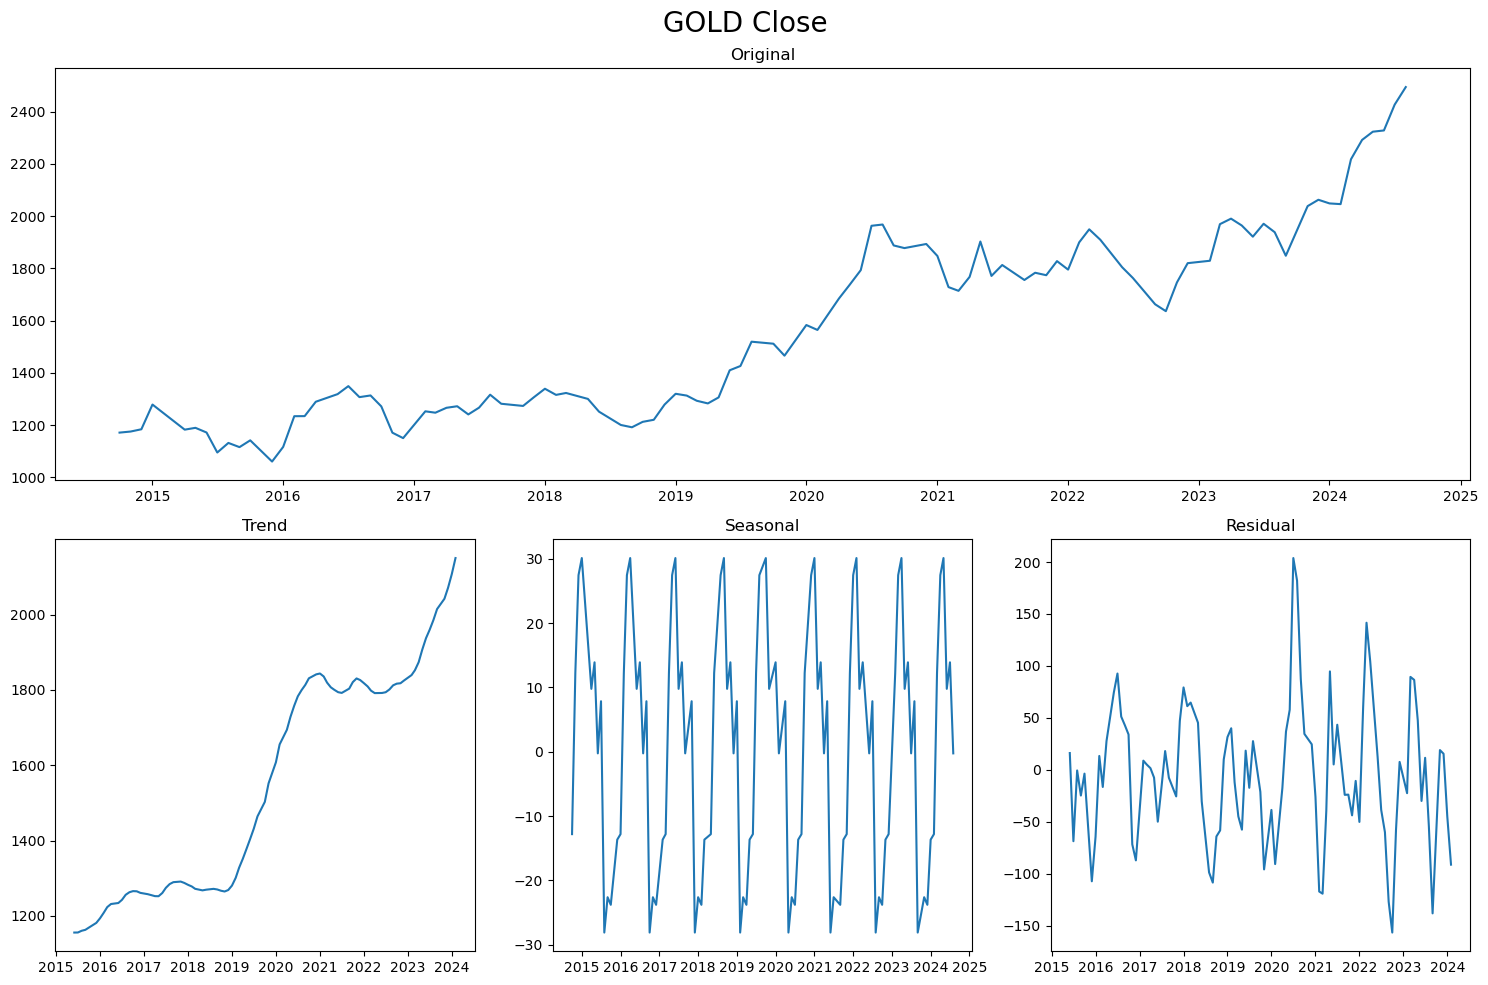

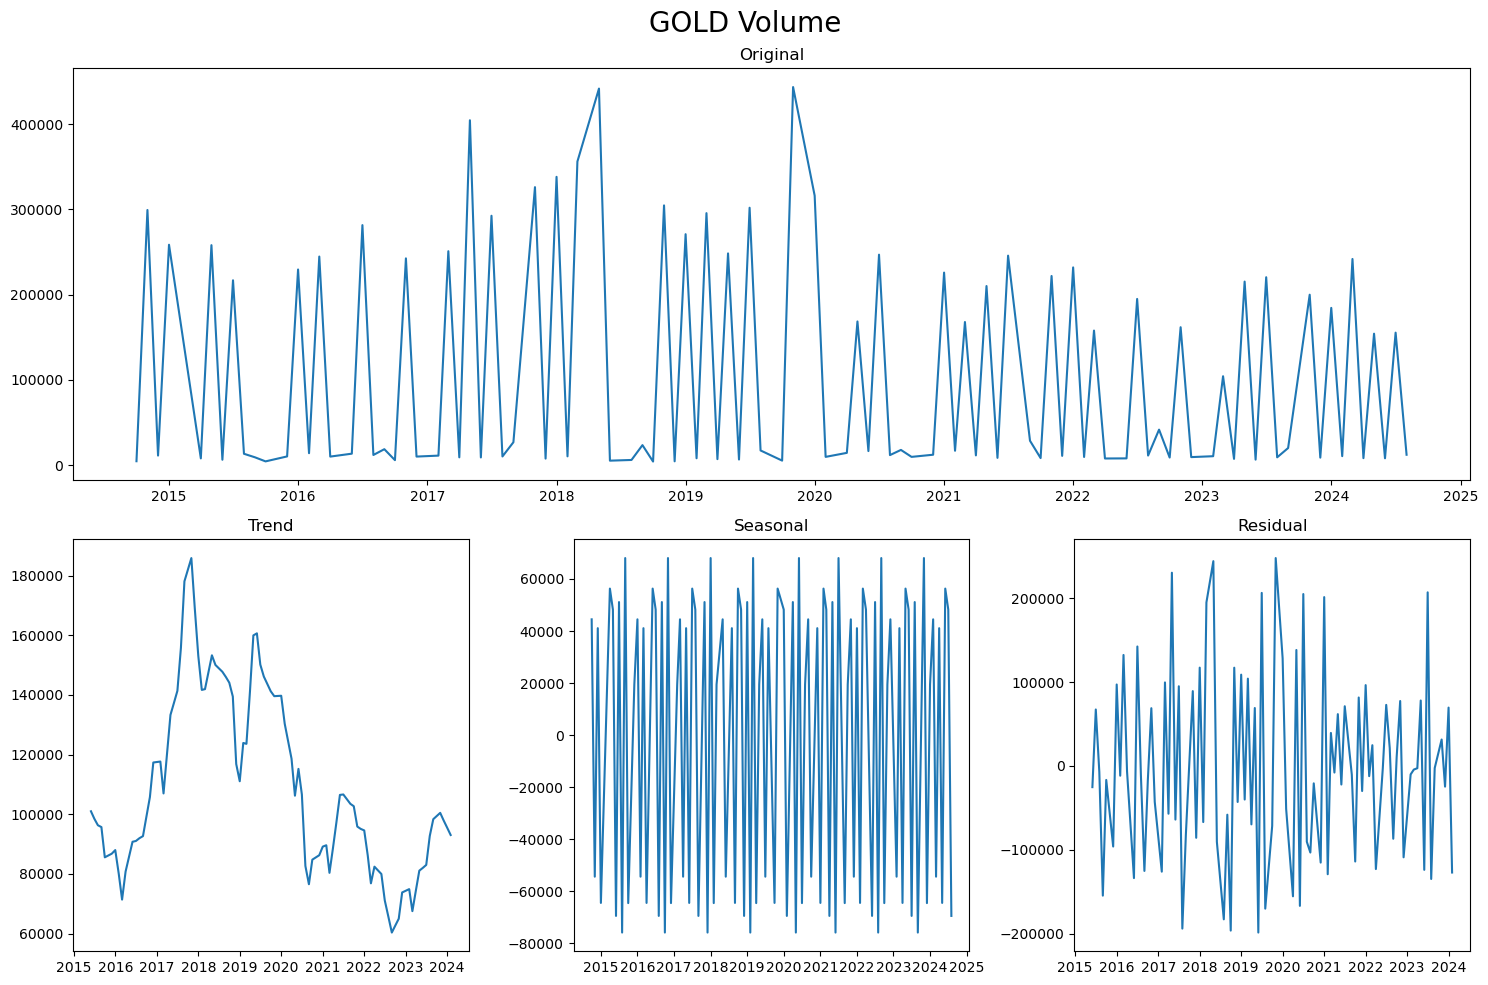

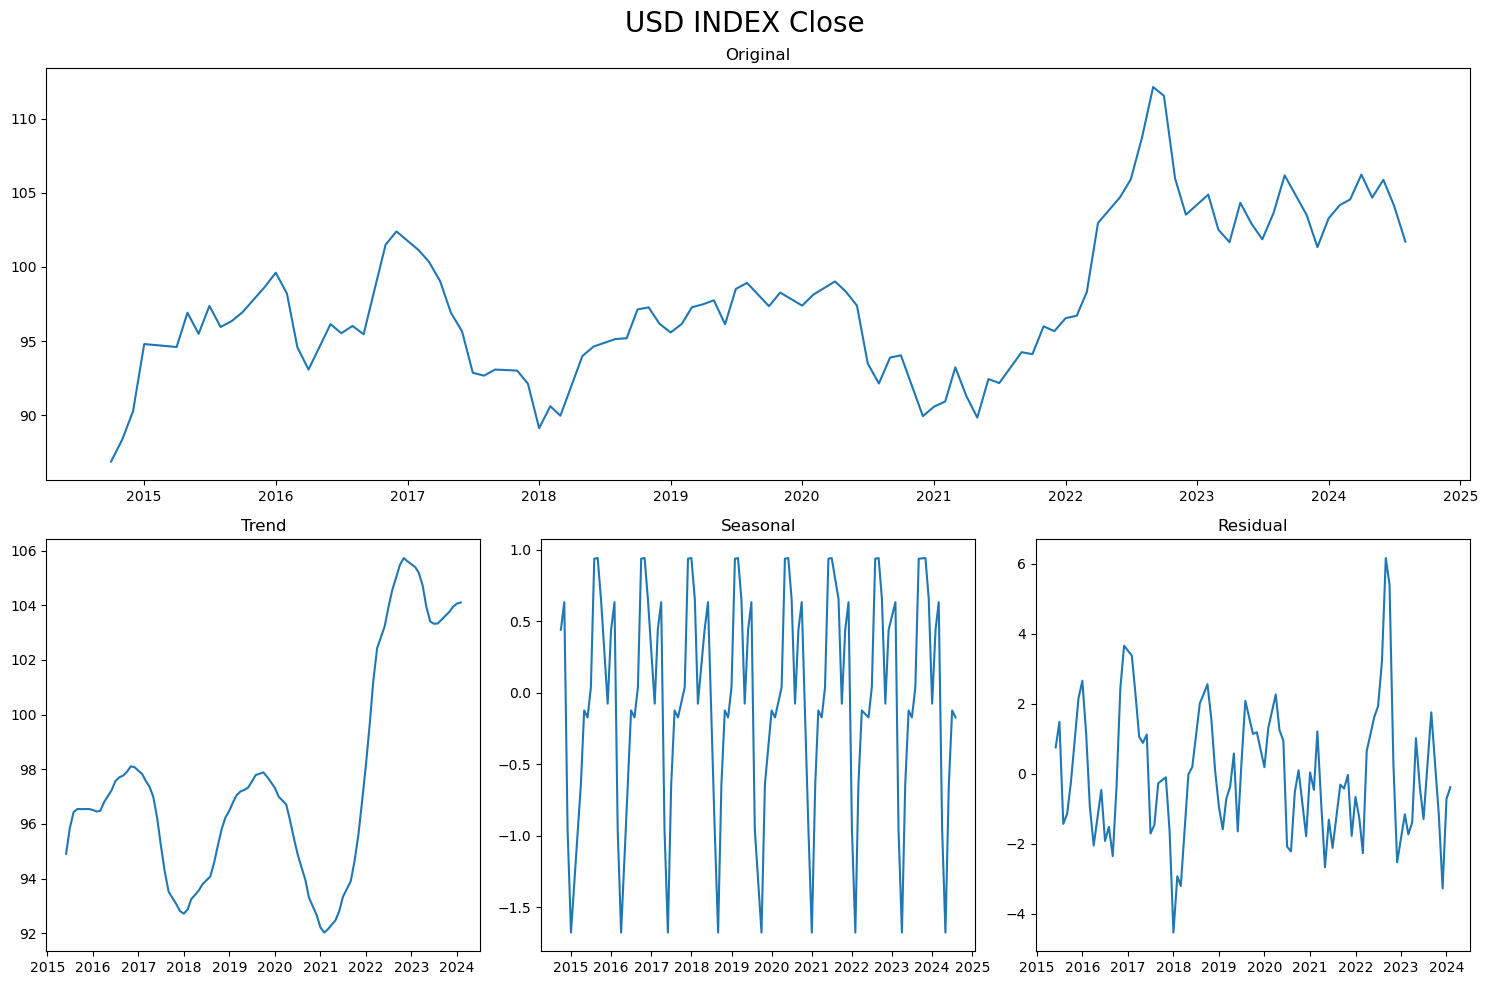

In [120]:
period = 12

for column in data_clean.columns:
    decompose_and_plot(data_clean[column], column, period)

In [51]:
# # #Generalized Additive Models 
# X = Features_clean['BBB Rate'].values.reshape(-1, 1)
# y = VIX

# gam = GAM(s(0, n_splines=10))
# gam.fit(X, y)

# XX = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
# gam_predictions = gam.predict(XX)

# plt.figure(figsize=(10,6))
# plt.scatter(X, y, alpha=0.1)
# plt.plot(XX, gam_predictions, color='r', linewidth=2)
# plt.title('GAM: VIX Vs BBB Rate')
# plt.xlabel('BBB Rate')
# plt.ylabel('VIX')
# plt.show()

# print(gam.summary())



In [121]:
#Scaling the data for the model
scaler = StandardScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(data_clean), columns=data_clean.columns)

In [54]:
scaled_df.describe()

VIX  Unemployment Rate           CPI  Three Month T Bill Rate  \
count  1.030000e+02       1.030000e+02  1.030000e+02             1.030000e+02   
mean  -4.419334e-17      -2.188109e-16  1.343046e-15            -2.328235e-16   
std    1.004890e+00       1.004890e+00  1.004890e+00             1.004890e+00   
min   -1.320615e+00      -7.450949e-01 -1.201094e+00            -9.033025e-01   
25%   -7.527012e-01      -5.812270e-01 -8.352193e-01            -8.494692e-01   
50%   -2.735784e-01      -3.627366e-01 -3.669192e-01            -3.703525e-01   
75%    6.415901e-01       1.288669e-01  8.917487e-01             3.644726e-01   
max    4.195890e+00       5.481883e+00  1.909047e+00             1.949864e+00   

       Six Month T Bill Rate  10-Year Treasury Constant Maturity Rate  \
count           1.030000e+02                             1.030000e+02   
mean            4.311546e-17                            -3.212102e-16   
std             1.004890e+00                             1.004890e+00   
min            -9.563584e-01                            -1.807790e+00   
25%            -8.905312e-01                            -7.019810e-01   
50%            -3.693992e-01                            -1.416383e-01   
75%             3.684139e-01                             5.426740e-01   
max             1.934553e+00                             2.079897e+00   

           Fed Rate      BBB Rate   SP500 Index  SP500 Volume  ...  \
count  1.030000e+02  1.030000e+02  1.030000e+02  1.030000e+02  ...   
mean  -4.613354e-16  5.734356e-16  7.200281e-16 -4.028601e-16  ...   
std    1.004890e+00  1.004890e+00  1.004890e+00  1.004890e+00  ...   
min   -8.901830e-01 -1.687103e+00 -1.342933e+00 -1.605600e+00  ...   
25%   -8.522099e-01 -6.251801e-01 -8.789903e-01 -6.088310e-01  ...   
50%   -2.934623e-01 -1.522230e-01 -3.492133e-01 -1.857887e-01  ...   
75%    3.846294e-01  6.419879e-01  8.370670e-01  4.760069e-01  ...   
max    1.974076e+00  1.998393e+00  2.208309e+00  3.646203e+00  ...   

        FTSE Volume  NIKKEI Adj Close  NIKKEI Volume           GDP  \
count  1.030000e+02      1.030000e+02   1.030000e+02  1.030000e+02   
mean  -1.207233e-16     -1.465926e-16   7.114050e-17 -2.957720e-15   
std    1.004890e+00      1.004890e+00   1.004890e+00  1.004890e+00   
min   -1.752832e+00     -1.439384e+00  -1.227997e+00 -1.278957e+00   
25%   -6.965472e-01     -7.241141e-01  -8.361173e-01 -8.466718e-01   
50%   -1.920024e-01     -2.756541e-01  -3.025589e-01 -2.918482e-01   
75%    4.819584e-01      5.838755e-01   7.465734e-01  8.727670e-01   
max    3.714300e+00      2.596536e+00   2.981162e+00  1.865600e+00   

       Initial Claims  JPY/USD Spot Rate  Spot Crude Oil Price  \
count    1.030000e+02       1.030000e+02          1.030000e+02   
mean    -2.155773e-17      -8.256610e-16         -5.044509e-16   
std      1.004890e+00       1.004890e+00          1.004890e+00   
min     -3.862212e-01      -1.199311e+00         -2.528156e+00   
25%     -3.315882e-01      -6.856933e-01         -7.375359e-01   
50%     -2.573433e-01      -4.328557e-01         -1.729906e-01   
75%     -1.541476e-01       3.762908e-01          7.618567e-01   
max      7.954422e+00       2.548245e+00          2.888063e+00   

       GOLD Adj Close   GOLD Volume  USD INDEX Adj Close  
count    1.030000e+02  1.030000e+02         1.030000e+02  
mean     1.250348e-16  3.988180e-17         1.382928e-15  
std      1.004890e+00  1.004890e+00         1.004890e+00  
min     -1.435420e+00 -8.105221e-01        -2.120790e+00  
25%     -8.494494e-01 -7.715516e-01        -6.869680e-01  
50%     -1.691613e-01 -7.302270e-01        -1.442563e-01  
75%      7.748488e-01  9.201523e-01         7.654990e-01  
max      2.588482e+00  2.650520e+00         2.833303e+00  

[8 rows x 27 columns]

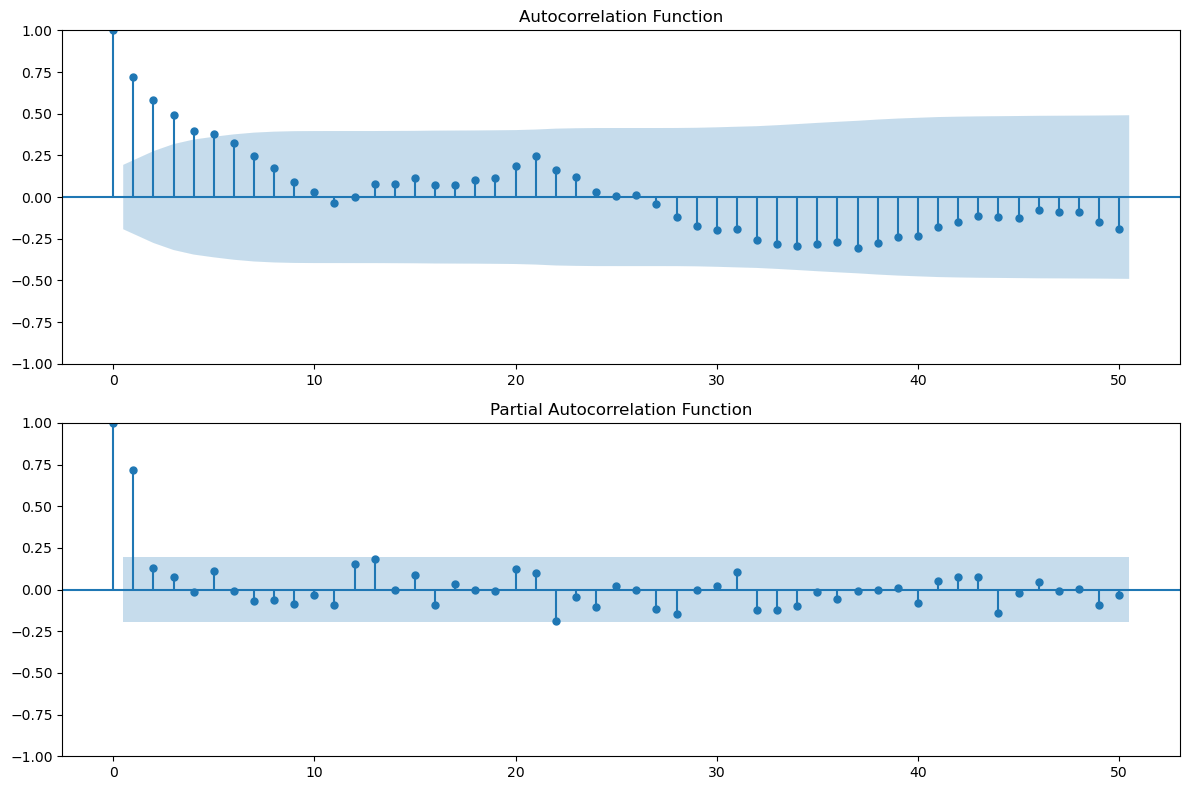

In [122]:
#ACF and PACF of original VIX data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

sm.graphics.tsa.plot_acf(data_clean['VIX'], lags=50, ax=ax1)
ax1.set_title('Autocorrelation Function')

sm.graphics.tsa.plot_pacf(data_clean['VIX'], lags=50, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

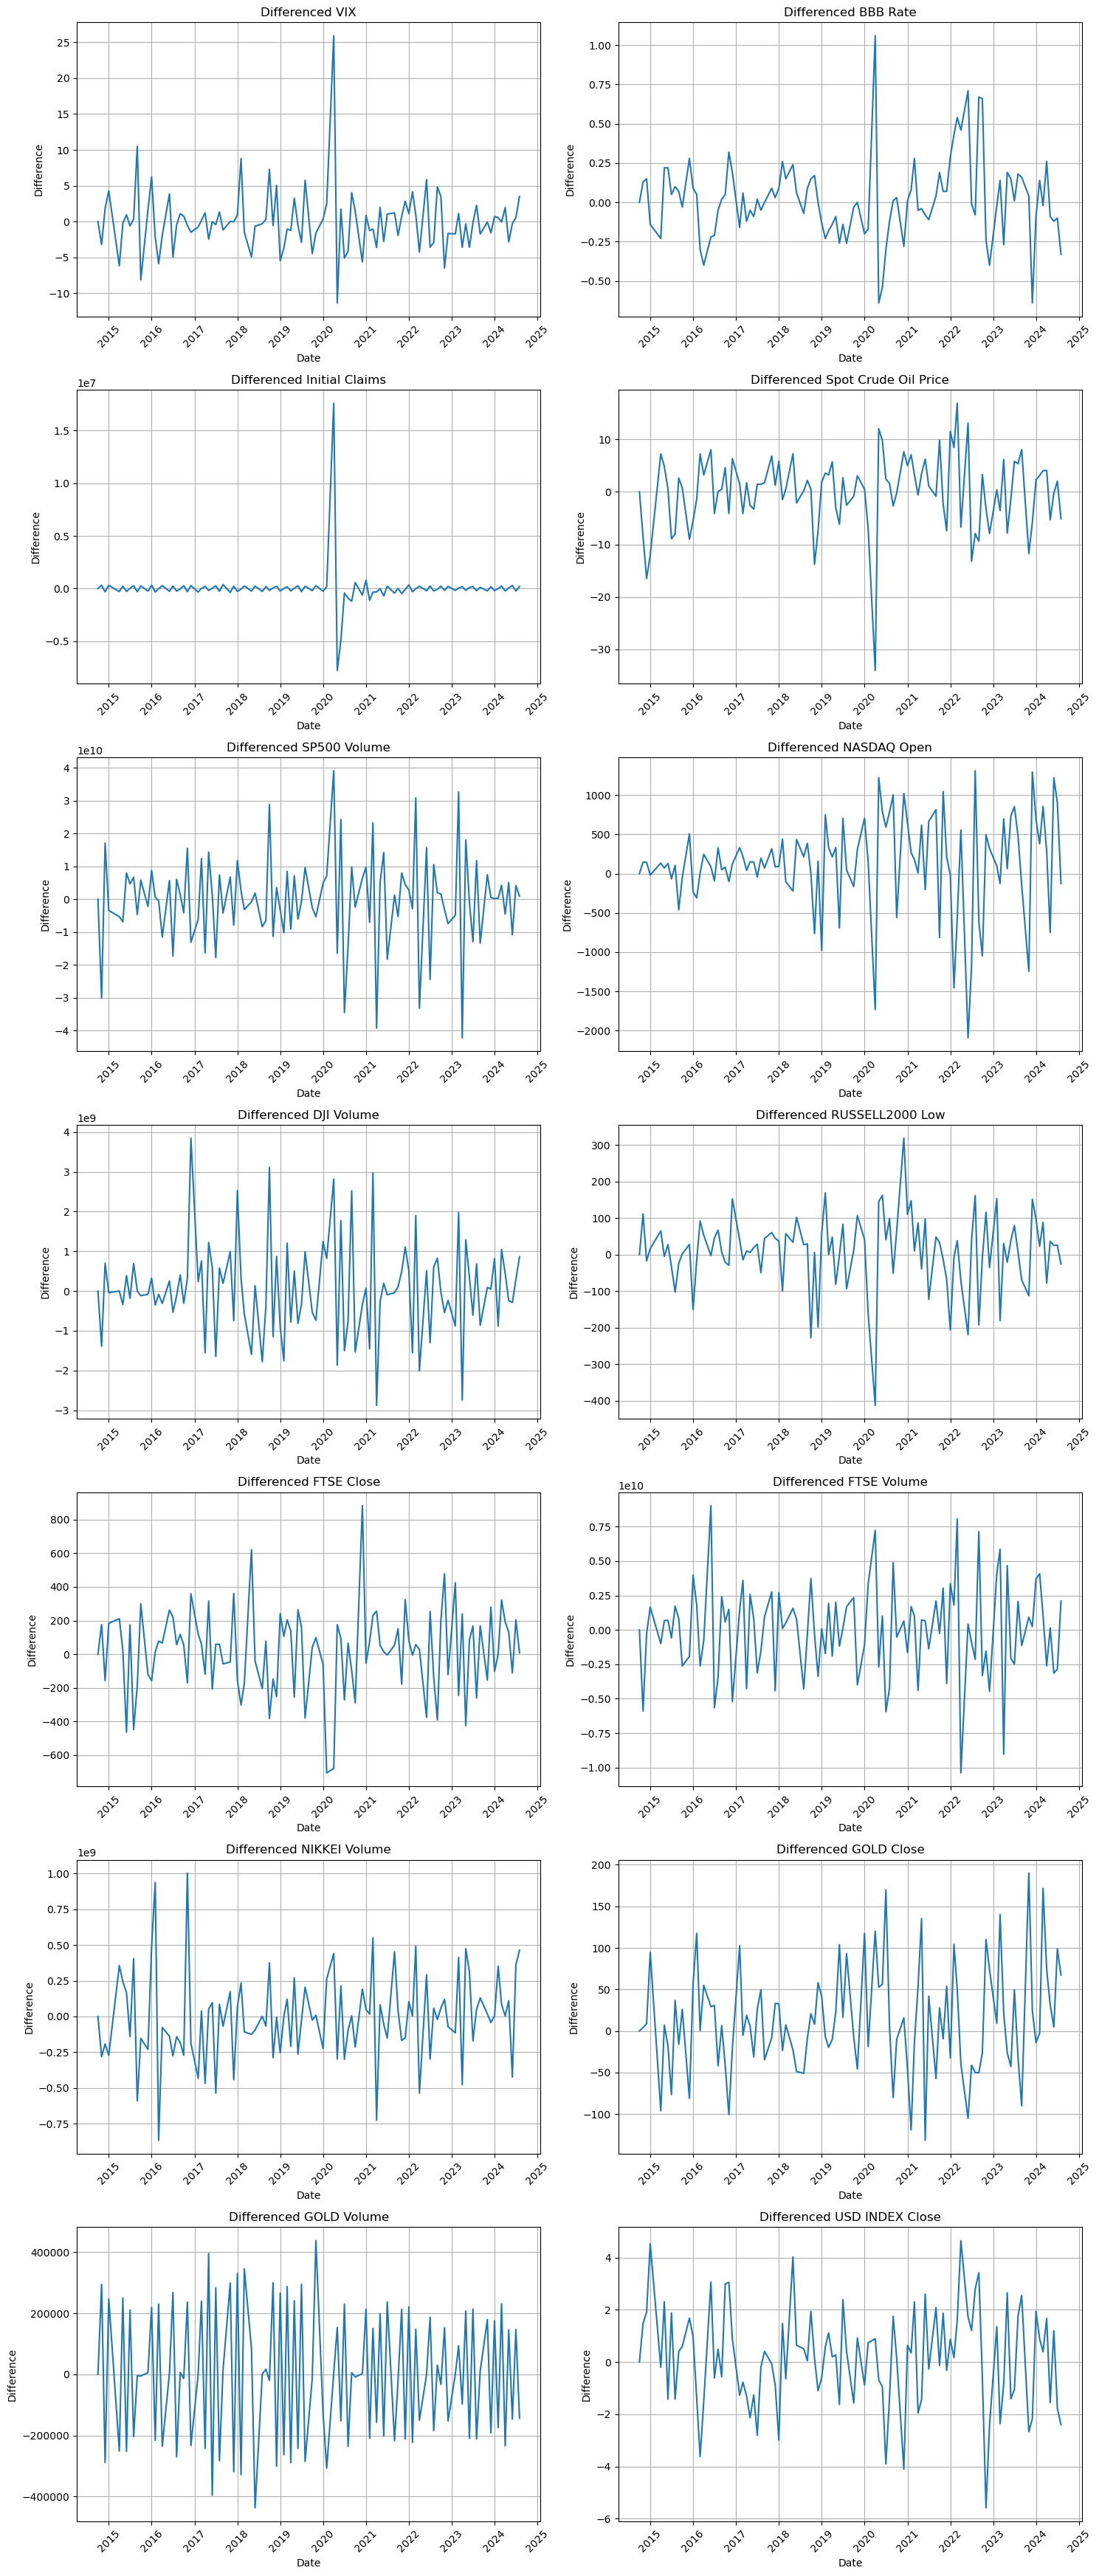

In [123]:
#Difference the Data

differenced_data = data_clean.diff() #First order differencing

differenced_data.iloc[0] = 0 #First entry of differenced data is typically NaN because there is no previous value to subtract from the first observation

num_columns = len(differenced_data.columns)

nrows = (num_columns + 1) // 2


plt.figure(figsize=(15, 5 * nrows))

for i, column in enumerate(differenced_data.columns):
    plt.subplot(nrows, 2, i + 1)
    plt.plot(differenced_data.index, differenced_data[column])
    plt.title(f'Differenced {column}')
    plt.xlabel('Date')
    plt.ylabel('Difference')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [124]:
#Check for NaN or infinite values

missing_values = differenced_data.isnull().sum() + (differenced_data == float('inf')).sum() + (differenced_data == float('-inf')).sum()
print(f'Number of missing or ifinite values: {missing_values}')

Number of missing or ifinite values: VIX                     0
BBB Rate                0
Initial Claims          0
Spot Crude Oil Price    0
SP500 Volume            0
NASDAQ Open             0
DJI Volume              0
RUSSELL2000 Low         0
FTSE Close              0
FTSE Volume             0
NIKKEI Volume           0
GOLD Close              0
GOLD Volume             0
USD INDEX Close         0
dtype: int64


In [125]:
#ADF / Augmented Dickey Fuller Test
def adfuller_test(series):
    adf_result = adfuller(series, autolag='AIC')
    return{
        'ADF Statistic': adf_result[0], 
        'p-value': adf_result[1],
        'Lags used': adf_result[2],
        'Observations used': adf_result[3],
        'Critical Values': adf_result[4]
        }

In [59]:
adf_results = differenced_data.apply(adfuller_test, axis=0)

In [126]:
adf_results.describe()

count                                                    27
unique                                                   27
top       {'ADF Statistic': -12.994877774073515, 'p-valu...
freq                                                      1
dtype: object

In [127]:
print(adf_results)

VIX                                        {'ADF Statistic': -12.994877774073515, 'p-valu...
Unemployment Rate                          {'ADF Statistic': -10.753585860668734, 'p-valu...
CPI                                        {'ADF Statistic': -4.778606942416463, 'p-value...
Three Month T Bill Rate                    {'ADF Statistic': -2.2457473179743075, 'p-valu...
Six Month T Bill Rate                      {'ADF Statistic': -2.773212010174554, 'p-value...
10-Year Treasury Constant Maturity Rate    {'ADF Statistic': -7.2908149953780725, 'p-valu...
Fed Rate                                   {'ADF Statistic': -2.5493826738826884, 'p-valu...
BBB Rate                                   {'ADF Statistic': -7.601264664281523, 'p-value...
SP500 Index                                {'ADF Statistic': -10.178219623329483, 'p-valu...
SP500 Volume                               {'ADF Statistic': -6.419780434213524, 'p-value...
NASDAQ Adj Close                           {'ADF Statistic': -4.454019

In [62]:
adf_results['VIX']

{'ADF Statistic': -12.994877774073515,
 'p-value': 2.763449691116139e-24,
 'Lags used': 0,
 'Observations used': 102,
 'Critical Values': {'1%': -3.4961490537199116,
  '5%': -2.8903209639580556,
  '10%': -2.5821223452518263}}

In [63]:
#KPSS / Kwiatkowski-Phillips-Schmidt-Shin Test
def kpss_test(series, **kw):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=InterpolationWarning)
    
        statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    return{
        'KPSS Statistic': statistic,
        'p_value': p_value,
        'num lags': n_lags,
        'Critical Values': critical_values
    }

In [64]:
kpss_results = differenced_data.apply(kpss_test, axis=0)

In [65]:
print(kpss_results.iloc[:1])

VIX    {'KPSS Statistic': 0.053273328034338985, 'p_va...
dtype: object


In [66]:
#Philips-Perron Test
pp_test = differenced_data.apply(PhillipsPerron)

In [67]:
pp_test[2]

/var/folders/p2/s867_82x1zb758ysgxvlj2yw0000gn/T/ipykernel_3590/2943326554.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pp_test[2]


<class 'arch.unitroot.unitroot.PhillipsPerron'>
"""
     Phillips-Perron Test (Z-tau)    
=====================================
Test Statistic                 -8.847
P-value                         0.000
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.50 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
"""

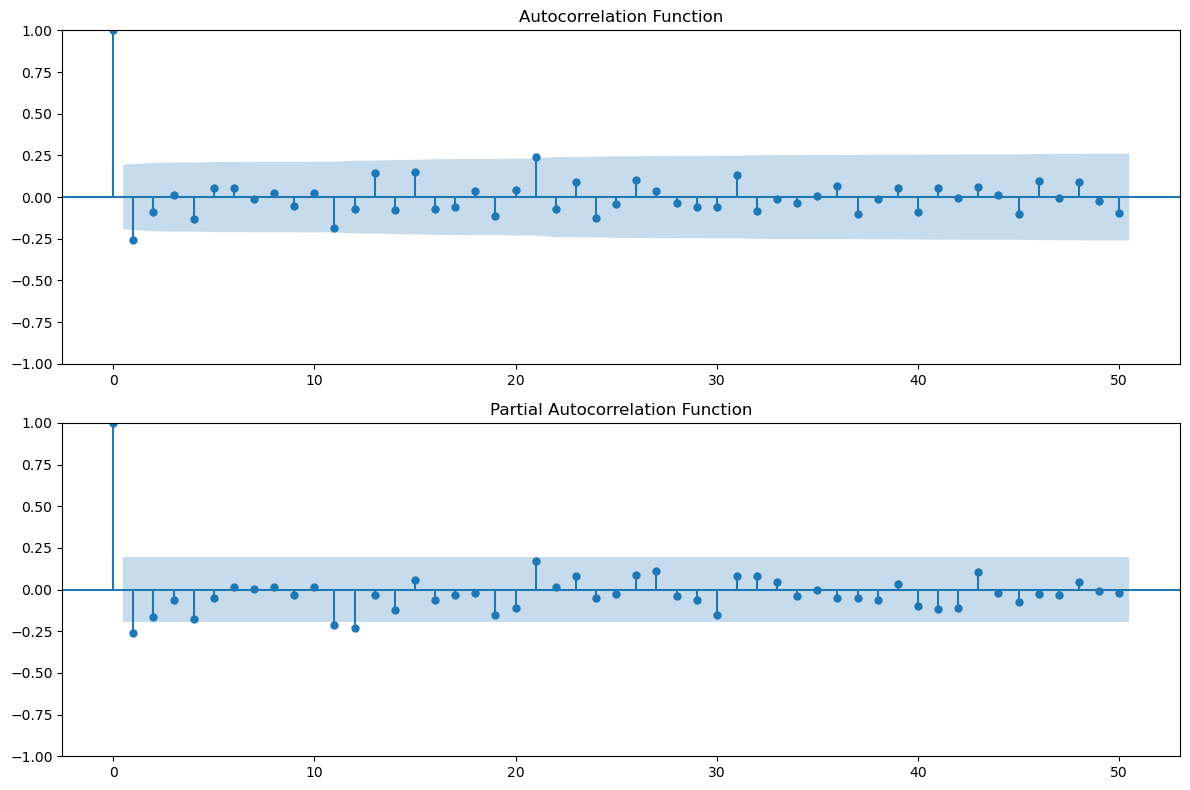

In [128]:
#ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

sm.graphics.tsa.plot_acf(differenced_data['VIX'], lags=50, ax=ax1)
ax1.set_title('Autocorrelation Function')

sm.graphics.tsa.plot_pacf(differenced_data['VIX'], lags=50, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


In [129]:
log_data = np.log1p(data_clean)

In [130]:
#Determine p, d, q values
def determine_p_d_q_values(timeseries, lags):
    #Calculate autocorrelation and partial autocorrelation values
    acf_values = acf(timeseries, nlags=lags)
    pacf_values = pacf(timeseries, nlags=lags)

    #Determine value of p
    p = 0
    for i in range(1, len(acf_values)):
        if abs(acf_values[i]) > 1.96 / len(timeseries) ** 0.5: #threshold for statistical significance of autocorrelation at 95% confidence level
                                                                #Crtical value for 95% confidence level in standard normal distribution = 1.96 
                                                                #Standard error of autocorrelation = 1.95*(1/sqrt(N)) for large samples
            p = i
            break

    #Determine value of d
    d = 0
    p_value_adf = adfuller(timeseries)[1]
    while p_value_adf > 0.05:
        timeseries = np.diff(timeseries)
        d += 1
        p_value_adf = adfuller(timeseries)[1]

    #Determine value of q
    q = 0
    for i in range(1, len(pacf_values)):
        if abs(pacf_values[i]) > 1.96 / len(timeseries) ** 0.5:
            q = i
            break

    return p, d, q

In [131]:
lags = 50
timeseries = log_data.iloc[:, 0]
exogenous_variables = log_data.iloc[:, 1:]

In [132]:
#Manual determination of p, d, q
p, d, q = determine_p_d_q_values(timeseries, lags)
print(f'p: {p}, d: {d}, q: {q}')

p: 1, d: 0, q: 1


In [133]:
#Determine p,d,q using auto_arima
auto_arima_model = auto_arima(timeseries, 
                              exogenous=exogenous_variables,
                              start_p=1, start_q=1, 
                              test='adf',
                              max_p=5, max_q=5,
                              m=12, #VIX data = monthly data with yearly seasonality
                              d=None,
                              seasonal=True,
                              start_P=1, start_Q=1,
                              D=None,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True
                              )

print(auto_arima_model.order)
print(auto_arima_model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-45.569, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-39.711, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-41.242, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-44.976, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-41.711, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-47.016, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-46.096, Time=0.14 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=-45.934, Time=0.91 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-46.201, Time=0.63 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=-43.968, Time=1.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-42.140, Time=0.09 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-45.020, Time=0.52 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-44.945, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-39.755, Time=0.11 sec
 ARIMA(0,1,2)(0,0,1)[12] intercep

In [134]:
p, d, q =auto_arima_model.order
P, D, Q, m = auto_arima_model.seasonal_order

In [135]:
print(f'p: {p}, d: {d}, q: {q}')
print(f'\nP: {P}, D: {D}, Q: {Q}')

p: 1, d: 1, q: 1

P: 0, D: 0, Q: 1


In [136]:
#Train and Test Data
train_size=int(len(log_data)*0.8)
train_data = log_data[:train_size]
test_data = log_data[train_size:]

train_target = train_data.iloc[:, 0] #VIX
test_target = test_data.iloc[:, 0]
train_exog = train_data.iloc[:, 1:]
test_exog = test_data.iloc[:, 1:]

In [137]:
#ARIMA model
arima_model = ARIMA(train_target, order=(p, d, q))
arima_results = arima_model.fit()

log_arima_forecast = arima_results.forecast(steps=len(test_target))

arima_forecast = np.exp(log_arima_forecast) #Back-transform to ensure non-negativity
arima_forecast = np.maximum(arima_forecast, 0)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [138]:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VIX   No. Observations:                   82
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  16.432
Date:                Wed, 06 Nov 2024   AIC                            -26.865
Time:                        15:58:48   BIC                            -19.681
Sample:                             0   HQIC                           -23.983
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5947      0.202      2.945      0.003       0.199       0.990
ma.L1         -0.8926      0.113     -7.896      0.000      -1.114      -0.671
sigma2         0.0388      0.003     12.590      0.000       0.033       0.045
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               147.40
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             1.80
Prob(H) (two-sided):                  0.36   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

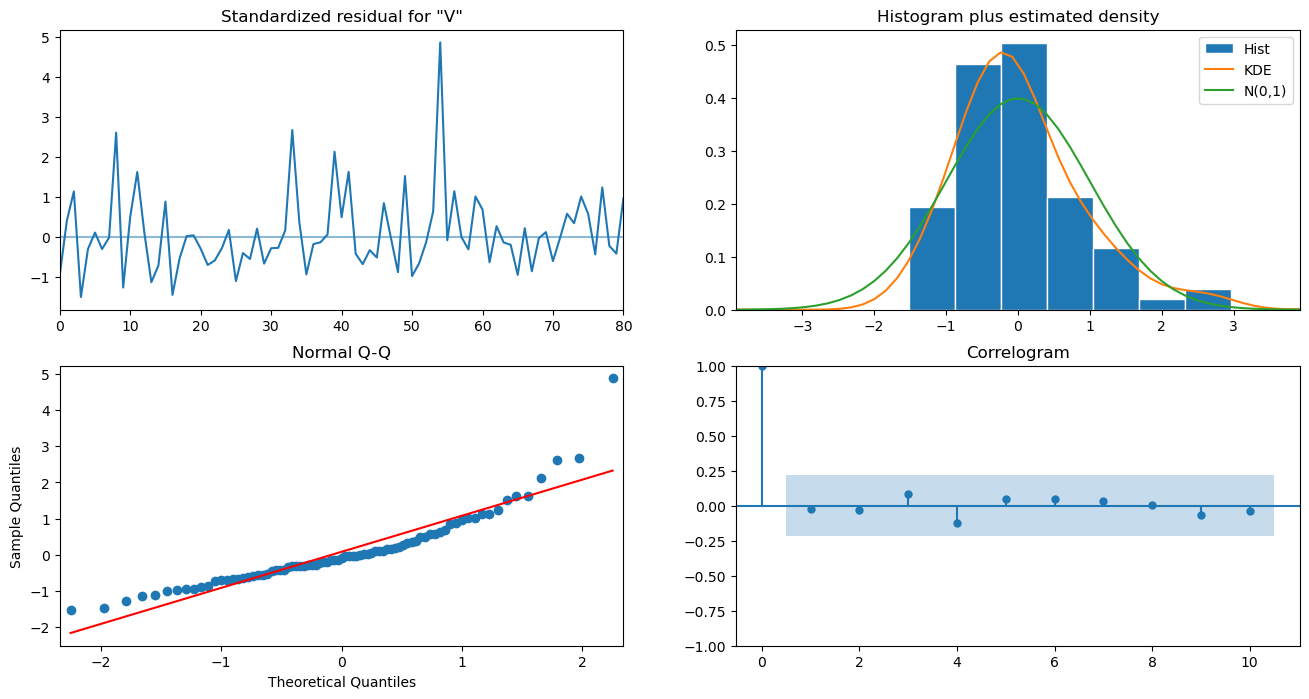

In [139]:
arima_results.plot_diagnostics(figsize=(16,8))
plt.show()

In [140]:
#ARIMAX model
arimax_model = SARIMAX(train_target, exog=train_exog, order=(p, d, q))
arimax_results = arimax_model.fit()

log_arimax_forecast = arimax_results.forecast(steps=len(test_target), exog=test_exog)

arimax_forecast = np.exp(log_arimax_forecast)
arimax_forecast = np.maximum(arimax_forecast, 0)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.43287D-01    |proj g|=  7.05814D-01

At iterate    5    f= -7.46780D-01    |proj g|=  4.33829D-01

At iterate   10    f= -7.50274D-01    |proj g|=  3.24336D-01

At iterate   15    f= -7.54776D-01    |proj g|=  1.86573D-01

At iterate   20    f= -7.55599D-01    |proj g|=  2.80754D-01

At iterate   25    f= -7.58929D-01    |proj g|=  1.28499D-01

At iterate   30    f= -7.59776D-01    |proj g|=  1.24934D-01

At iterate   35    f= -7.64046D-01    |proj g|=  1.44033D-01

At iterate   40    f= -7.66919D-01    |proj g|=  1.89647D-01

At iterate   45    f= -7.67566D-01    |proj g|=  1.02427D-01

At iterate   50    f= -7.73124D-01    |proj g|=  5.20016D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [141]:
arimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VIX   No. Observations:                   82
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  63.396
Date:                Wed, 06 Nov 2024   AIC                            -94.792
Time:                        15:59:03   BIC                            -56.481
Sample:                             0   HQIC                           -79.421
                                 - 82                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
BBB Rate                 0.5848      0.245      2.386      0.017       0.104       1.065
Initial Claims           0.0637      0.062      1.030      0.303      -0.058       0.185
Spot Crude Oil Price     0.0462      0.124      0.373      0.709      -0.196       0.289
SP500 Volume             0.2184      0.238      0.918      0.359      -0.248       0.685
NASDAQ Open              0.6592      0.353      1.870      0.061      -0.032       1.350
DJI Volume               0.0614      0.139      0.443      0.658      -0.210       0.333
RUSSELL2000 Low         -0.9183      0.376     -2.445      0.014      -1.654      -0.182
FTSE Close              -1.3678      0.461     -2.968      0.003      -2.271      -0.465
FTSE Volume              0.1972      0.147      1.344      0.179      -0.090       0.485
NIKKEI Volume           -0.1154      0.190     -0.607      0.544      -0.488       0.257
GOLD Close               0.5272      0.341      1.547      0.122      -0.141       1.195
GOLD Volume             -0.0066      0.008     -0.839      0.402      -0.022       0.009
USD INDEX Close          0.2091      0.658      0.318      0.751      -1.081       1.500
ar.L1                   -0.0504      0.239     -0.210      0.833      -0.519       0.419
ma.L1                   -0.5962      0.225     -2.646      0.008      -1.038      -0.154
sigma2                   0.0115      0.002      7.102      0.000       0.008       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                15.62
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.69
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

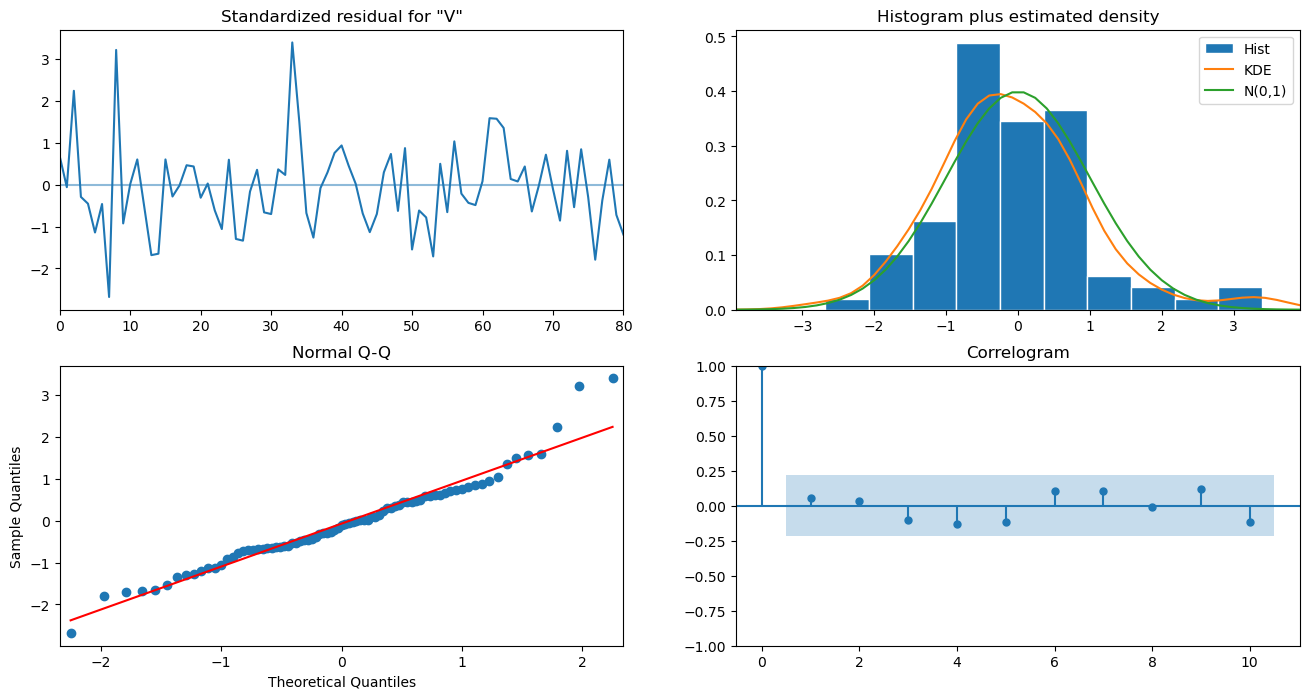

In [142]:
arimax_results.plot_diagnostics(figsize=(16,8))
plt.show()

In [143]:
#SARIMAX model
P=1
D=1
Q=1 #Can change later
sarimax_model = SARIMAX(train_target,
                        exog=train_exog,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, m)
                        )

sarimax_results = sarimax_model.fit()

log_sarimax_forecast = sarimax_results.forecast(steps=len(test_target), exog=test_exog)

sarimax_forecast = np.exp(log_sarimax_forecast)
sarimax_forecast = np.maximum(sarimax_forecast, 0)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.23991D-01    |proj g|=  7.06024D-01

At iterate    5    f= -4.32915D-01    |proj g|=  5.24507D-01

At iterate   10    f= -4.62063D-01    |proj g|=  1.21058D-01

At iterate   15    f= -4.72099D-01    |proj g|=  3.27829D-01

At iterate   20    f= -4.92289D-01    |proj g|=  6.41323D-01

At iterate   25    f= -5.02114D-01    |proj g|=  1.51618D-01

At iterate   30    f= -5.07770D-01    |proj g|=  2.95018D-01

At iterate   35    f= -5.23281D-01    |proj g|=  5.87243D-01

At iterate   40    f= -5.33200D-01    |proj g|=  1.26615D-01

At iterate   45    f= -5.36634D-01    |proj g|=  9.33543D-02

At iterate   50    f= -5.38957D-01    |proj g|=  2.20361D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [144]:
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                VIX   No. Observations:                   82
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  44.194
Date:                            Wed, 06 Nov 2024   AIC                            -52.389
Time:                                    15:59:14   BIC                            -12.175
Sample:                                         0   HQIC                           -36.435
                                             - 82                                         
Covariance Type:                              opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
BBB Rate                 1.0397      0.238      4.360      0.000       0.572       1.507
Initial Claims           0.0741      0.072      1.033      0.301      -0.066       0.215
Spot Crude Oil Price    -0.0144      0.133     -0.108      0.914      -0.276       0.247
SP500 Volume             0.5455      0.272      2.002      0.045       0.012       1.079
NASDAQ Open              1.0056      0.359      2.803      0.005       0.302       1.709
DJI Volume              -0.0919      0.071     -1.286      0.198      -0.232       0.048
RUSSELL2000 Low         -0.5669      0.408     -1.389      0.165      -1.367       0.233
FTSE Close              -1.2447      0.567     -2.195      0.028      -2.356      -0.133
FTSE Volume              0.1810      0.174      1.041      0.298      -0.160       0.522
NIKKEI Volume           -0.2710      0.134     -2.015      0.044      -0.535      -0.007
GOLD Close               0.6516      0.371      1.758      0.079      -0.075       1.378
GOLD Volume             -0.0102      0.010     -1.055      0.291      -0.029       0.009
USD INDEX Close         -0.1081      0.650     -0.166      0.868      -1.382       1.166
ar.L1                    0.0931      0.187      0.499      0.618      -0.273       0.459
ma.L1                   -0.8816      0.152     -5.797      0.000      -1.180      -0.584
ar.S.L12                 0.0371      0.305      0.122      0.903      -0.562       0.636
ma.S.L12                -0.9736      4.259     -0.229      0.819      -9.321       7.374
sigma2                   0.0118      0.048      0.247      0.805      -0.082       0.106
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.94   Prob(JB):                         0.77
Heteroskedasticity (H):               0.40   Skew:                            -0.21
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

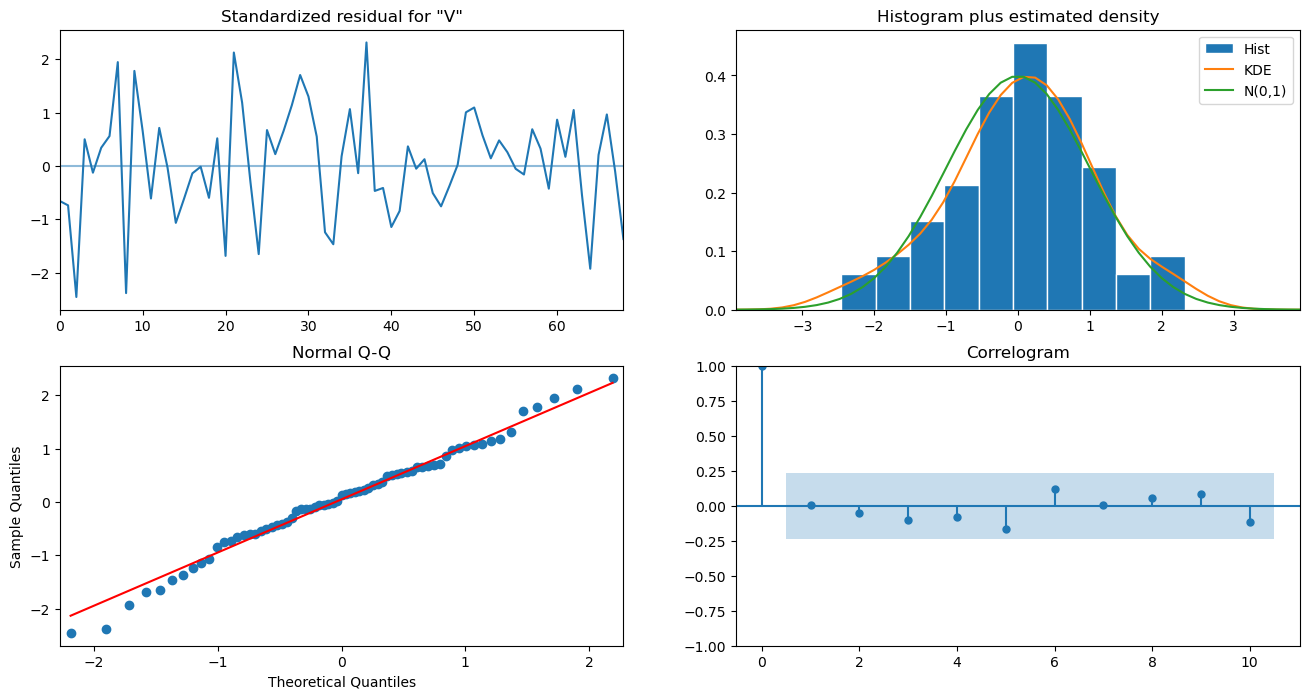

In [145]:
sarimax_results.plot_diagnostics(figsize=(16,8))
plt.show()

In [148]:
#Error Functions: MSE, MAPE, Direction Accuracy, RMSE, R2-score
def calculate_metrics(model_name, y_true, y_pred):
    #Convert inputs to numpy arrays of floats
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)

    #Add small epsilon to avoid division by zero in MAPE calculation
    epsilon = 1e-10
    
    #MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    #Mean Absolute Percentage Error
    mape = mean_absolute_percentage_error(y_true, y_pred)

    #Direction Accurancy
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    direction_accuracy = np.mean(direction_true == direction_pred) * 100

    #RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    #R2-score
    r2 = r2_score(y_true, y_pred)

    return { 
        'Model' : model_name,
        'MSE' : mse,
        'MAPE' : mape,
        'Direction Accuracy' : direction_accuracy,
        'RMSE' : rmse,
        'R2-score' : r2
    }

In [149]:
arima_metrics = calculate_metrics('ARIMA', np.exp(test_target), arima_forecast)
arimax_metrics = calculate_metrics('ARIMAX', np.exp(test_target), arimax_forecast)
sarimax_metrics = calculate_metrics('SARIMAX', np.exp(test_target), sarimax_forecast)

for metrics in [arima_metrics, arimax_metrics, sarimax_metrics]:
    print(f'\n Metrics for {metrics['Model']}:')
    for key, value in metrics.items():
        if key != 'Model':
            print(f'{key}: {value:.2f}')


 Metrics for ARIMA:
MSE: 60.95
MAPE: 0.46
Direction Accuracy: 65.00
RMSE: 7.81
R2-score: -2.12

 Metrics for ARIMAX:
MSE: 90.70
MAPE: 0.55
Direction Accuracy: 75.00
RMSE: 9.52
R2-score: -3.64

 Metrics for SARIMAX:
MSE: 88.66
MAPE: 0.54
Direction Accuracy: 55.00
RMSE: 9.42
R2-score: -3.53


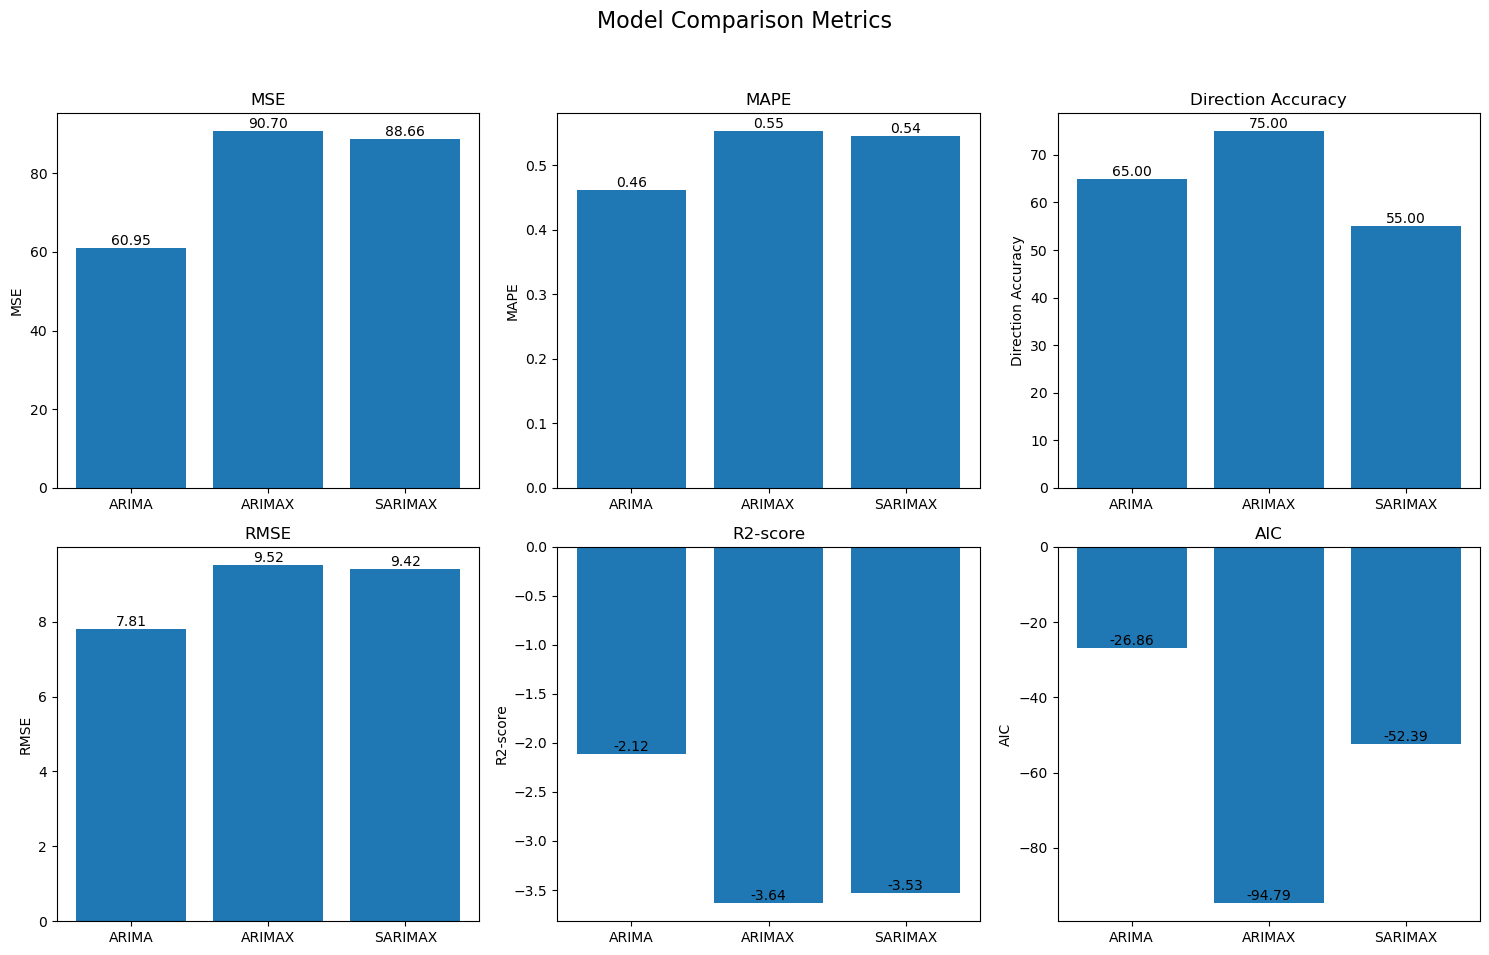

In [150]:
#Plot Error Functions
models = ['ARIMA', 'ARIMAX', 'SARIMAX']

metrics_list = [arima_metrics, arimax_metrics, sarimax_metrics]

aic_values = {
    'ARIMA' : arima_results.aic,
    'ARIMAX' : arimax_results.aic,
    'SARIMAX' : sarimax_results.aic
}

aic = [aic_values[model] for model in models]

#Create dictionary to store all metrics
all_metrics = {
    'MSE' : {},
    'MAPE' : {},
    'Direction Accuracy' : {},
    'RMSE' : {},
    'R2-score' : {},
    'AIC' : aic_values
}

#Populate the all_metrics dictionary
for metrics in metrics_list:
    model = metrics['Model']
    for key, value in metrics.items():
        if key != 'Model':
            all_metrics[key][model] = value

#Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Model Comparison Metrics', fontsize=16)

axs = axs.flatten()

# colors = ['deep', 'muted', 'pastel']

for i, (metric, values) in enumerate(all_metrics.items()):
    ax = axs[i]
    metric_values = [values.get(model, np.nan) for model in models]
    
    bars = ax.bar(models, metric_values)
    ax.set_ylabel(metric)
    ax.set_title(metric)

    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', 
                ha='center', va='bottom', rotation=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

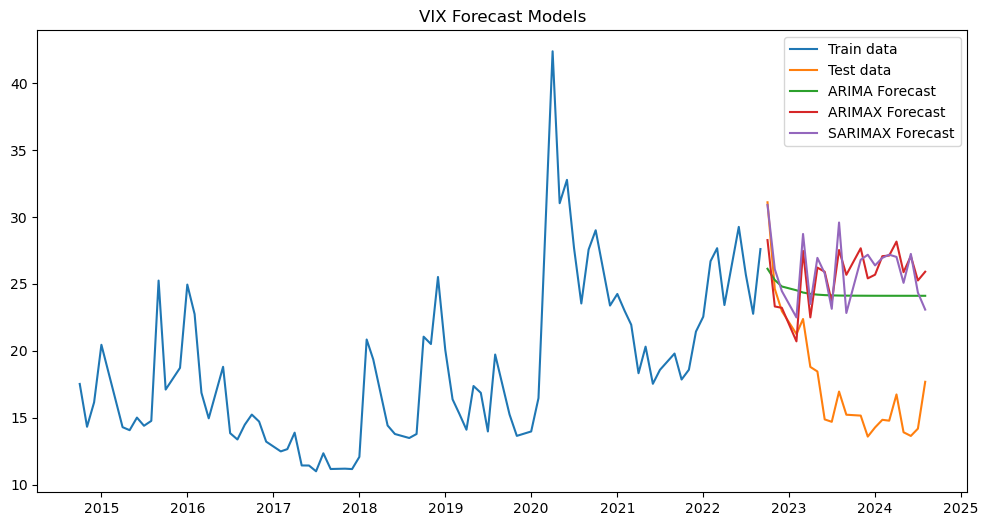

In [151]:
#Plot the model forecasts
plt.figure(figsize = (12, 6))
plt.plot(train_target.index, np.exp(train_target), label='Train data')
plt.plot(test_target.index, np.exp(test_target), label='Test data')
plt.plot(test_target.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test_target.index, arimax_forecast, label='ARIMAX Forecast')
plt.plot(test_target.index, sarimax_forecast, label='SARIMAX Forecast')

plt.legend(loc='best')
plt.title('VIX Forecast Models')
plt.show()
